In [1]:
# Filter tensorflow version warnings
import os
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warn£ing
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import sys

if sys.platform == "win32":
    path = os.path.abspath(os.path.join(os.path.dirname("__file__"),".."))
    os.chdir(path)
else:
    sys.path.append("../")

In [3]:
sess = tf.Session(config=tf.ConfigProto(
    device_count={"CPU": 1, "GPU": 1},
    inter_op_parallelism_threads=0,
    allow_soft_placement=True,
    gpu_options={"allow_growth": True},
    intra_op_parallelism_threads=0,
    ))

In [4]:
from parameters import prepare_kwargs
data_kwargs, model_kwargs, agent_kwargs, _ = prepare_kwargs(start_date='2018-01-01',
                                                            end_date='2020-10-12',
                                                            model_name="Separated_new",
                                                            hidden_size=64,
                                                            hidden_sizes=[64, 32, 16, 8, 4],
                                                            agent_name="201209_272_scale_10_vf_05_stupid_squared_big_lr_000005_ent_005_heating",
                                                            rooms=["272"],
                                                            algorithm="PPO2",
                                                            vf_loss_coef=0.5,
                                                            small_obs=True,
                                                            cooling=False,
                                                            temp_bounds=[20, 22, 23, 25],
                                                            agent_lr=0.00005,
                                                            ent_coef=0.05,
                                                            gamma=0.95,
                                                            price_levels=[1],
                                                            price_type="Constant",
                                                            lstm_size=256,
                                                            extraction_size=128,
                                                            vf_layers=[128, 128],
                                                            pi_layers=[128, 128],
                                                            n_envs=8)


In [5]:
import numpy as np

def compute_reward(environment, observation, action):
    """
    Small helper function to compute temperature rewards
    """

    reward = 0
    energy_scale = 10

    # Get the current temperatures
    temperatures = environment.scale_back_temperatures(
        environment.current_data[
            environment.n_autoregression + environment.current_step, environment.predictions_columns[
                                                                     :len(environment.rooms)]])

    bounds = (environment.current_data[environment.n_autoregression + environment.current_step, -2:] - 0.1) / 0.8 * (
                environment.temp_bounds[-1] - environment.temp_bounds[0]) + environment.temp_bounds[0]

    too_low = np.where(temperatures < bounds[0])[0]
    too_high = np.where(temperatures > bounds[1])[0]
    right = np.where((temperatures > bounds[0]) & (temperatures < bounds[1]))[0]

    electricity_from_grid = environment.compute_electricity_from_grid(observation, action)
    energy = electricity_from_grid * energy_scale
    
    reward -= energy
                
    if len(too_low) > 0:
        reward += np.sum(temperatures[too_low] - bounds[0])
        if observation[-5] > 0.8999:
            reward -= np.sum((1 - (action[:-1][too_low] - 0.1) / 0.8) * (temperatures[too_low] - bounds[0]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((action[:-1][too_low] - 0.1) / 0.8 * (temperatures[too_low] - bounds[0]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    if len(too_high) > 0:
        reward += np.sum(bounds[1] - temperatures[too_high])
        if observation[-5] > 0.8999:
            reward -= np.sum((action[:-1][too_high] - 0.1) / 0.8 * (bounds[1] - temperatures[too_high]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((1 - (action[:-1][too_high] - 0.1) / 0.8) * (bounds[1] - temperatures[too_high]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    return reward, temperatures, bounds

In [6]:
from agents.agents import Agent
agents = {}
types = {}

rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
rl_names = ["Last agent", "Best price", "Best comfort", "Best agent"]

for name in rl_names:
    agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                         load_best="Best agent" in name, load_best_comfort="comfort" in name,
                         load_best_price="price" in name)
    types[name] = "RL"

agents["Unavoidable"] = agents["Best agent"].unavoidable
agents["Bang-bang"] = agents["Best agent"].bangbang
agents["Rule-based"] = agents["Best agent"].rbagent

for name in rb_names:
    types[name] = "RB"



Usage of the TensorBoard is off!


Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Preparing the data...
Trying to load the full data...
Data downloaded sucessfully!
Dropped 6514 inconsistent points
Dropped 281 inconsistent points

Data ready!

Constructing the LSTM models...
Indeed, the output is currently passed through a sigmoid which crushes it between 0 and 1

Trying to load a trained model...
Found!
The model has been fitted for 388 epochs already, with loss  0.00164.
Trying to load the predictable indices, where the data has no missing values...
Found!
Trying to load the predictable indices, where the data has no missing values...
Found!
Computing common sequences
Checking the environment...
Creating the subprocesses...
Ready!
Creating the evaluation environment...

Preparing the rule-based agent

Preparing the bang-bang agent

Preparing the unavoidable agent
Rule-based performance on the testing set:
Rewards:      

In [9]:
import os
import warnings
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Union, Optional, List, Dict, Any

from stable_baselines.common.vec_env import VecEnv, DummyVecEnv, sync_envs_normalization

from agents.helpers import evaluate_lstm_policy, prepare_performance_plot, analyze_agent
from agents.environments import UMAREnv

from abc import ABC
import typing

from stable_baselines import logger

if typing.TYPE_CHECKING:
    from stable_baselines.common.base_class import BaseRLModel  # pytype: disable=pyi-error
    
    
def prepare_agents(data_kwargs, model_kwargs, agent_kwargs, compute_reward, compute_reward2, rl_names=None):
    
    agents = {}
    types = {}
    
    rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
    if rl_names is None:
        rl_names = ["Best comfort agent", "Best price agent", "Last agent", "Best reward agent"]
    
    for name in rl_names:
        agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                             load_best="reward" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
        types[name] = "RL"
        
    agents["Unavoidable"] = agents["Best reward agent"].unavoidable
    agents["Bang-bang"] = agents["Best reward agent"].bangbang
    agents["Rule-based"] = agents["Best reward agent"].rbagent
    
    for name in rb_names:
        types[name] = "RB"
    
    return agents, types

def analysis(agents, types, eval_env, sequences,
             print_: bool = False, print_frequency: int = 25,
             plot_: bool = False, plot_frequency: int = 25,
                 normalizing: bool = False,
                 deterministic: bool = True,
                 verbose: int = 1):

    # Convert to VecEnv for consistency
    if not isinstance(eval_env, VecEnv) and not isinstance(eval_env, UMAREnv):
        eval_env = DummyVecEnv([lambda: eval_env])
        assert eval_env.num_envs == 1, "You must pass only one environment for evaluation"

    _eval_env = eval_env

    if isinstance(eval_env, UMAREnv):
        eval_env = _eval_env
    else:
        if normalizing:
            eval_env = _eval_env.venv.venv.envs[0]
        else:
            eval_env = _eval_env.venv.envs[0]
            
    rewards = {name: [] for name in agents.keys()}
    comfort_violations = {name: [] for name in agents.keys()}
    prices = {name: [] for name in agents.keys()}
            
    for num, sequence in enumerate(sequences):
                
        if num % 50 == 49:
            print(num+1)
        
        for i, name in enumerate(agents.keys()):
            
            if types[name] == "RL":
        
                evaluate_lstm_policy(agents[name].model,
                                     eval_env,
                                     n_eval_episodes=1,
                                     sequence=sequence,
                                     render=False,
                                     deterministic=deterministic,
                                     normalizing=normalizing,
                                     all_goals=False,
                                     return_episode_rewards=True)
            
                rewards[name].append(eval_env.last_rewards)
                comfort_violations[name].append(eval_env.last_comfort_violations)
                prices[name].append(eval_env.last_prices)
            
            else:
        
                agents[name].run(sequence,
                                 eval_env.last_goal_number,
                                 render=False)

                rewards[name].append(agents[name].env.last_rewards)
                comfort_violations[name].append(agents[name].env.last_comfort_violations)
                prices[name].append(agents[name].env.last_prices)
                
            if print_ & (num % print_frequency == 0):
        
                print(f"__________________________\n\n{name}:")
                print(f"\nReward: {np.sum(np.array(rewards[name][-1])):.2f}  -  ", end="")
                print(f"Comfort violations:   {np.sum(np.array(comfort_violations[name][-1])):.2f}  -  ", end="")
                print(f"Total benefits/costs: {np.sum(np.array(prices[name][-1])):.2f}", end="")
                
            if plot_ & (num % plot_frequency == 0):
                
                if types[name] == "RL":
                    env = eval_env
                else:
                    env = agents[name].env

                axes, data = prepare_performance_plot(env=env,
                                                   sequence=env.last_sequence,
                                                   data=env.last_data,
                                                   rewards=env.last_rewards,
                                                   electricity_imports=env.last_electricity_imports,
                                                   lower_bounds=env.last_lower_bounds,
                                                   upper_bounds=env.last_upper_bounds,
                                                   prices=env.last_prices,
                                                   comfort_violations=env.last_comfort_violations,
                                                   battery_soc=env.last_battery_soc,
                                                   battery_powers=env.last_battery_powers,
                                                   label=name,
                                                   elec_price=True if i == 0 else False,
                                                   print_=True if i == 0 else False,
                                                   show_=True if i == len(agents)-1 else False,
                                                    axes=axes if i != 0 else None)


        if plot_ & (num % plot_frequency == 0):
            plt.tight_layout()
            plt.show()
            plt.close()
        
    return rewards, comfort_violations, prices


In [10]:
rewards, comfort_violations, prices = analysis(agents, types, eval_env=agents["Best agent"].eval_env,
         sequences=agents["Best agent"].env.venv.envs[0].umar_model.room_models[agent_kwargs["rooms"][0]].test_sequences[500:1500])

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


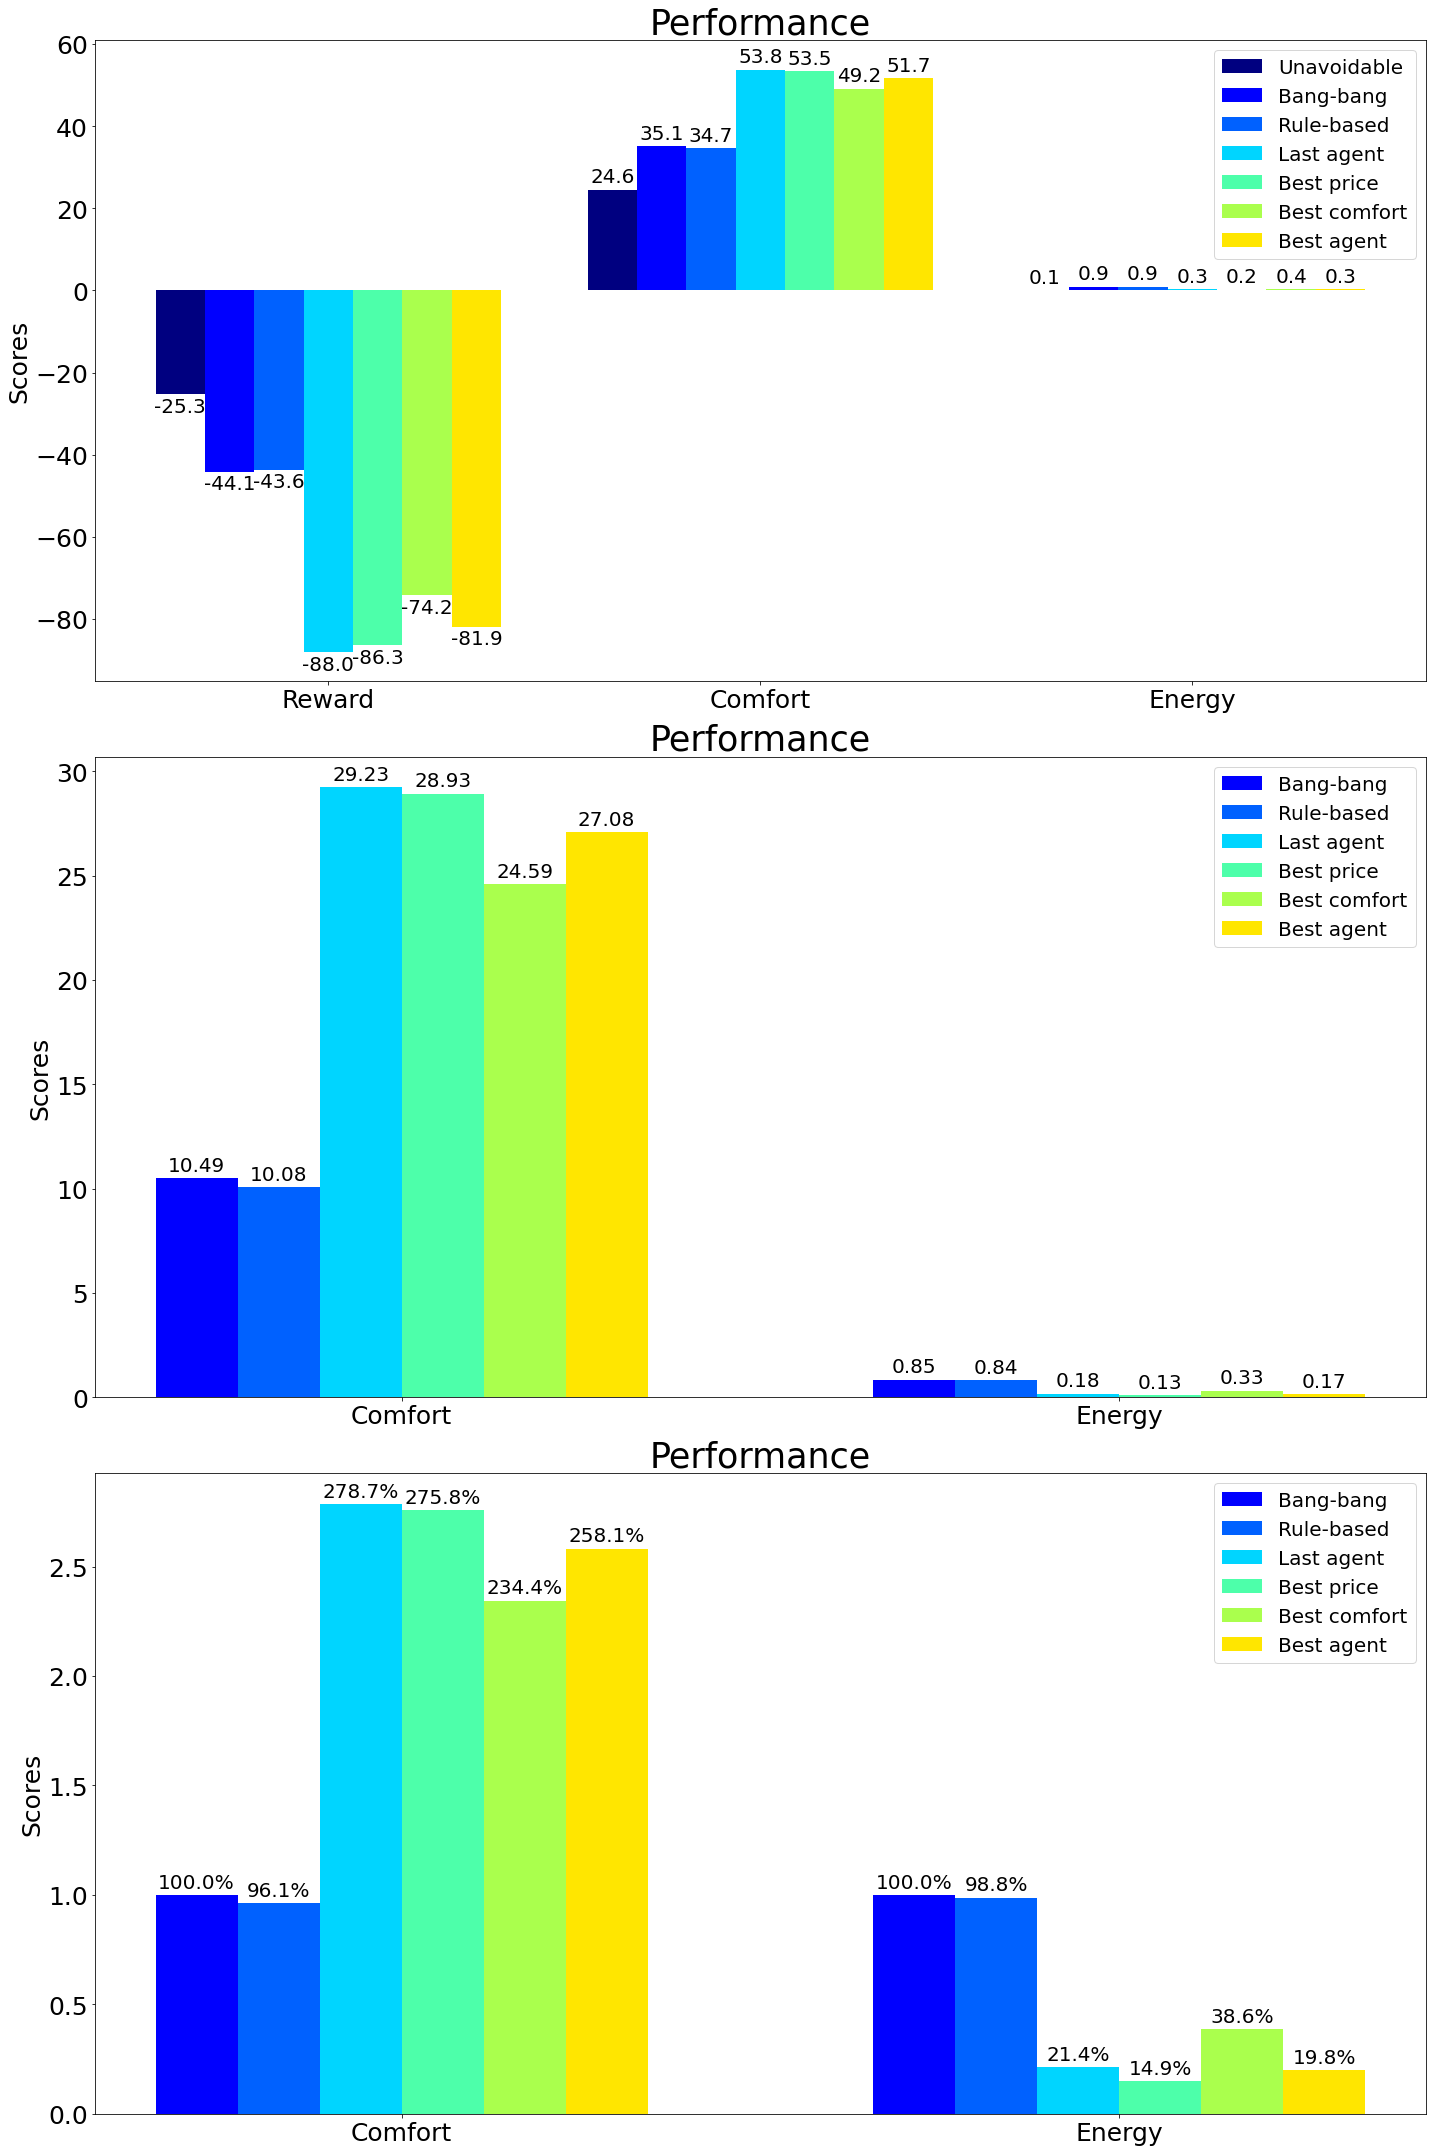

In [11]:
def autolabel(rects, axis, perc=False, small=False):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate(f'{height*100:.1f}%' if perc else f'{height:.1f}' if small else f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3) if height > 0 else (0, -3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top', size=20)
            

def bar_plot_comparison(rewards, comfort_violations, prices):
    
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))

    labels = ["Reward", "Comfort", "Energy"]
    
    data = {}
    for agent in rewards.keys():
        data[agent] = np.array([np.mean([np.sum(x) for x in rewards[agent]]),
                               np.mean([np.sum(x) for x in comfort_violations[agent]]),
                               np.mean([np.sum(x) for x in prices[agent]])])

    x = np.arange(len(labels))  # the label locations
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    ordered_labels = [x for x in ["Unavoidable", "Bang-bang", "Rule-based", "Last agent", "Best price", "Best comfort", "Best agent"] if x in rewards.keys()]
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, 10))
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[0].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[0], small=True) for x in bars]
    ax[0].set_xticklabels(labels)
    ax[0].set_xticks(x)

    for agent in rewards.keys():
        if agent != "Unavoidable":
            data[agent] -= data["Unavoidable"]
    del data["Unavoidable"]

    width = 0.8/len(data.keys()) 

    del ordered_labels[0] 
    colors = colors[1:,:]
    del labels[0]
    for key in data.keys():
        data[key] = data[key][1:]
    x = np.arange(len(labels))
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[1].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[1]) for x in bars]
    ax[1].set_xticklabels(labels)
    ax[1].set_xticks(x)
    
    data2 = {}
    for agent in data.keys():
        data2[agent] = np.array([np.std([np.sum(x) for x in rewards[agent]]),
                               np.std([np.sum(x) for x in comfort_violations[agent]]),
                               np.std([np.sum(x) for x in prices[agent]])])    

    div = data["Bang-bang"].copy()
    for agent in data.keys():
        data[agent] /= div
        
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[2].bar(pos, data[agent], width, label=agent, color=colors[i]))

    [autolabel(x, ax[2], perc=True) for x in bars]
    ax[2].set_xticklabels(labels)
    ax[2].set_xticks(x)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    for axis in ax:
        axis.set_ylabel('Scores', size=25)
        axis.set_title('Performance', size=35)
        axis.tick_params(axis="x", which="major", labelsize=25)
        axis.tick_params(axis="y", which="major", labelsize=25)
        axis.legend()
        axis.legend(prop={'size': 20})

    fig.tight_layout()
    plt.savefig(os.path.join("saves", "Figures", "Performance_nice.pdf"), format="pdf")
    plt.show()
    
    
bar_plot_comparison(rewards, comfort_violations, prices)

In [12]:
if not os.path.isdir(os.path.join("saves", "Experiments", agent_kwargs["name"])):
    os.mkdir(os.path.join("saves", "Experiments", agent_kwargs["name"]))
    
data = pd.DataFrame({key: [np.mean(x) for x in rewards[key]] for key in rewards.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "rewards.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in comfort_violations[key]] for key in comfort_violations.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "comfort.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in prices[key]] for key in prices.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "prices.csv"))

In [4]:
from parameters import prepare_kwargs
data_kwargs, model_kwargs, agent_kwargs, _ = prepare_kwargs(start_date='2018-01-01',
                                                            end_date='2020-10-12',
                                                            model_name="ARX_0",
                                                            agent_name="201211_272_Toy_scale_10_vf_05_lr_000005_ent_0.05_squared_scaled_30_no_cliping",
                                                            rooms=["272"],
                                                            algorithm="PPO2",
                                                            simple_env=True,
                                                            discrete=False,
                                                            backup=False,
                                                            agent_lr=0.00005,
                                                            ent_coef=0.05,
                                                            vf_loss_coef=0.5,
                                                            small_obs=True,
                                                            normalizing=False,
                                                            battery=False,
                                                            temp_bounds=[20, 22, 23, 25],
                                                            ddpg=False,
                                                            gamma=0.95,
                                                            price_levels=[1],
                                                            price_type="Constant",
                                                            lstm_size=128,
                                                            extraction_size=64,
                                                            vf_layers=[64, 64],
                                                            pi_layers=[64, 64],
                                                            n_envs=8)


In [5]:
import numpy as np

def compute_reward(environment, observation, action):
    """
    Small helper function to compute temperature rewards
    """

    reward = 0
    energy_scale = 10

    # Get the current temperatures
    temperatures = environment.scale_back_temperatures(
        environment.current_data[
            environment.n_autoregression + environment.current_step, environment.predictions_columns[
                                                                     :len(environment.rooms)]])

    bounds = (environment.current_data[environment.n_autoregression + environment.current_step, -2:] - 0.1) / 0.8 * (
                environment.temp_bounds[-1] - environment.temp_bounds[0]) + environment.temp_bounds[0]

    too_low = np.where(temperatures < bounds[0])[0]
    too_high = np.where(temperatures > bounds[1])[0]
    right = np.where((temperatures > bounds[0]) & (temperatures < bounds[1]))[0]

    electricity_from_grid = environment.compute_electricity_from_grid(observation, action)
    energy = electricity_from_grid * energy_scale
    
    reward -= energy
                
    if len(too_low) > 0:
        reward += np.sum(temperatures[too_low] - bounds[0])
        if observation[-5] > 0.8999:
            reward -= np.sum((1 - (action[:-1][too_low] - 0.1) / 0.8) * (temperatures[too_low] - bounds[0]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((action[:-1][too_low] - 0.1) / 0.8 * (temperatures[too_low] - bounds[0]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    if len(too_high) > 0:
        reward += np.sum(bounds[1] - temperatures[too_high])
        if observation[-5] > 0.8999:
            reward -= np.sum((action[:-1][too_high] - 0.1) / 0.8 * (bounds[1] - temperatures[too_high]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((1 - (action[:-1][too_high] - 0.1) / 0.8) * (bounds[1] - temperatures[too_high]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")
    return reward/30, temperatures, bounds

In [6]:
from agents.agents import Agent
agents = {}
types = {}

rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
rl_names = ["Last agent", "Best price", "Best comfort", "Best agent"]

for name in rl_names:
    agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                         load_best="Best agent" in name, load_best_comfort="comfort" in name,
                         load_best_price="price" in name)
    types[name] = "RL"

agents["Unavoidable"] = agents["Best agent"].unavoidable
agents["Bang-bang"] = agents["Best agent"].bangbang
agents["Rule-based"] = agents["Best agent"].rbagent

for name in rb_names:
    types[name] = "RB"



Usage of the TensorBoard is off!


Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Checking the environment...
Creating the subprocesses...
Ready!
Creating the evaluation environment...

Preparing the rule-based agent

Preparing the bang-bang agent

Preparing the unavoidable agent
Rule-based performance on the testing set:
Rewards:              -1.03 +/- 0.77.
Comfort violations:   20.50 +/- 20.70.
Prices:               1.08 +/- 0.56.

Bang-bang performance on the testing set:
Rewards:              -1.04 +/- 0.82.
Comfort violations:   21.70 +/- 22.10.
Prices:               1.01 +/- 0.58.

Unavoidable performance on the testing set:
Rewards:              -0.19 +/- 0.34.
Comfort violations:   5.04 +/- 9.09.
Prices:               0.08 +/- 0.23.

Trying to load an agent...
Found!

Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Checking the environment...
Creating

In [7]:
import os
import warnings
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Union, Optional, List, Dict, Any

from stable_baselines.common.vec_env import VecEnv, DummyVecEnv, sync_envs_normalization

from agents.helpers import evaluate_lstm_policy, prepare_performance_plot, analyze_agent
from agents.environments import UMAREnv

from abc import ABC
import typing

from stable_baselines import logger

if typing.TYPE_CHECKING:
    from stable_baselines.common.base_class import BaseRLModel  # pytype: disable=pyi-error
    
    
def prepare_agents(data_kwargs, model_kwargs, agent_kwargs, compute_reward, compute_reward2, rl_names=None):
    
    agents = {}
    types = {}
    
    rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
    if rl_names is None:
        rl_names = ["Best comfort agent", "Best price agent", "Last agent", "Best reward agent"]
    
    for name in rl_names:
        agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                             load_best="reward" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
        types[name] = "RL"
        
    agents["Unavoidable"] = agents["Best reward agent"].unavoidable
    agents["Bang-bang"] = agents["Best reward agent"].bangbang
    agents["Rule-based"] = agents["Best reward agent"].rbagent
    
    for name in rb_names:
        types[name] = "RB"
    
    return agents, types

def analysis(agents, types, eval_env, indices,
             print_: bool = False, print_frequency: int = 25,
             plot_: bool = False, plot_frequency: int = 25,
                 normalizing: bool = False,
                 deterministic: bool = True,
                 verbose: int = 1):

    # Convert to VecEnv for consistency
    if not isinstance(eval_env, VecEnv) and not isinstance(eval_env, UMAREnv):
        eval_env = DummyVecEnv([lambda: eval_env])
        assert eval_env.num_envs == 1, "You must pass only one environment for evaluation"

    _eval_env = eval_env

    if isinstance(eval_env, UMAREnv):
        eval_env = _eval_env
    else:
        if normalizing:
            eval_env = _eval_env.venv.venv.envs[0]
        else:
            eval_env = _eval_env.venv.envs[0]
            
    rewards = {name: [] for name in agents.keys()}
    comfort_violations = {name: [] for name in agents.keys()}
    prices = {name: [] for name in agents.keys()}
            
    for num, index in enumerate(indices):
        
        sequence = np.arange(index-20, index+96)
        
        if num % 50 == 49:
            print(num+1)
        
        for i, name in enumerate(agents.keys()):
            
            if types[name] == "RL":
        
                evaluate_lstm_policy(agents[name].model,
                                     eval_env,
                                     n_eval_episodes=1,
                                     sequence=sequence,
                                     render=False,
                                     deterministic=deterministic,
                                     normalizing=normalizing,
                                     all_goals=False,
                                     return_episode_rewards=True)
            
                rewards[name].append(eval_env.last_rewards)
                comfort_violations[name].append(eval_env.last_comfort_violations)
                prices[name].append(eval_env.last_prices)
            
            else:
        
                agents[name].run(sequence,
                                 eval_env.last_goal_number,
                                 render=False)

                rewards[name].append(agents[name].env.last_rewards)
                comfort_violations[name].append(agents[name].env.last_comfort_violations)
                prices[name].append(agents[name].env.last_prices)
                
            if print_ & (num % print_frequency == 0):
        
                print(f"__________________________\n\n{name}:")
                print(f"\nReward: {np.sum(np.array(rewards[name][-1])):.2f}  -  ", end="")
                print(f"Comfort violations:   {np.sum(np.array(comfort_violations[name][-1])):.2f}  -  ", end="")
                print(f"Total benefits/costs: {np.sum(np.array(prices[name][-1])):.2f}", end="")
                
            if plot_ & (num % plot_frequency == 0):
                
                if types[name] == "RL":
                    env = eval_env
                else:
                    env = agents[name].env

                axes, data = prepare_performance_plot(env=env,
                                                   sequence=env.last_sequence,
                                                   data=env.last_data,
                                                   rewards=env.last_rewards,
                                                   electricity_imports=env.last_electricity_imports,
                                                   lower_bounds=env.last_lower_bounds,
                                                   upper_bounds=env.last_upper_bounds,
                                                   prices=env.last_prices,
                                                   comfort_violations=env.last_comfort_violations,
                                                   battery_soc=env.last_battery_soc,
                                                   battery_powers=env.last_battery_powers,
                                                   label=name,
                                                   elec_price=True if i == 0 else False,
                                                   print_=True if i == 0 else False,
                                                   show_=True if i == len(agents)-1 else False,
                                                    axes=axes if i != 0 else None)


        if plot_ & (num % plot_frequency == 0):
            plt.tight_layout()
            plt.show()
            plt.close()
        
    return rewards, comfort_violations, prices


In [8]:
indices = agents["Best agent"].env.venv.envs[0].umar_model.test_indices
indices = [index for num, index in enumerate(indices) if num % 5 == 0]

In [9]:
len(indices)

1142

In [10]:
rewards, comfort_violations, prices = analysis(agents, types, eval_env=agents["Best agent"].eval_env,
         indices=indices)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100


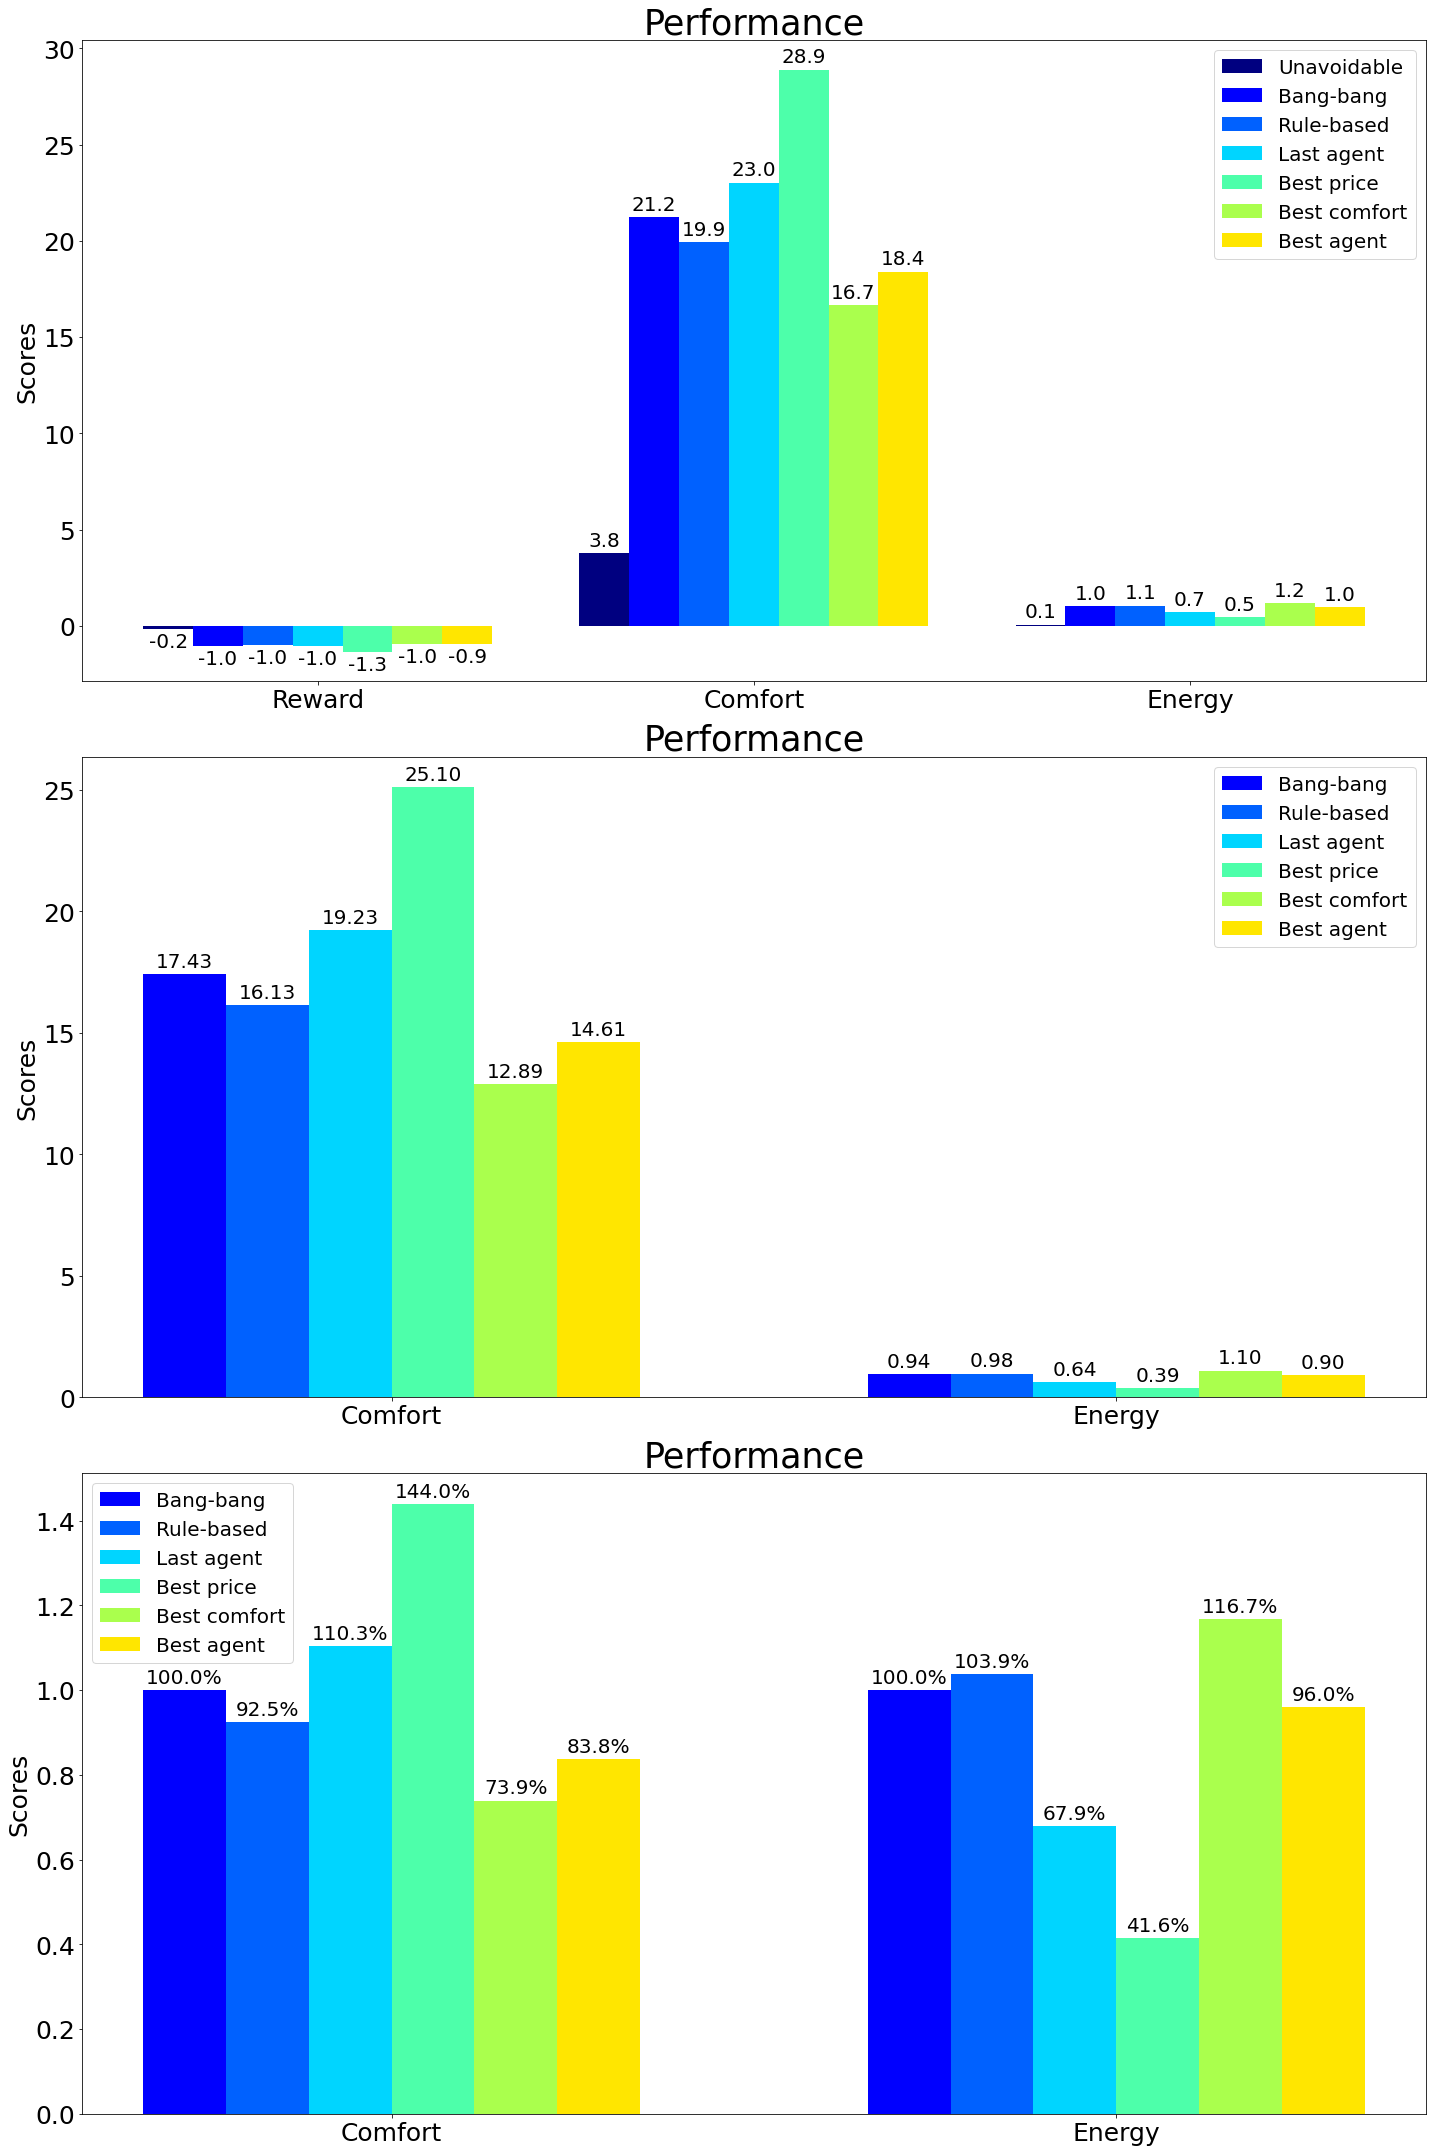

In [11]:
def autolabel(rects, axis, perc=False, small=False):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate(f'{height*100:.1f}%' if perc else f'{height:.1f}' if small else f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3) if height > 0 else (0, -3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top', size=20)
            

def bar_plot_comparison(rewards, comfort_violations, prices):
    
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))

    labels = ["Reward", "Comfort", "Energy"]
    
    data = {}
    for agent in rewards.keys():
        data[agent] = np.array([np.mean([np.sum(x) for x in rewards[agent]]),
                               np.mean([np.sum(x) for x in comfort_violations[agent]]),
                               np.mean([np.sum(x) for x in prices[agent]])])

    x = np.arange(len(labels))  # the label locations
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    ordered_labels = [x for x in ["Unavoidable", "Bang-bang", "Rule-based", "Last agent", "Best price", "Best comfort", "Best agent"] if x in rewards.keys()]
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, 10))
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[0].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[0], small=True) for x in bars]
    ax[0].set_xticklabels(labels)
    ax[0].set_xticks(x)

    for agent in rewards.keys():
        if agent != "Unavoidable":
            data[agent] -= data["Unavoidable"]
    del data["Unavoidable"]

    width = 0.8/len(data.keys()) 

    del ordered_labels[0] 
    colors = colors[1:,:]
    del labels[0]
    for key in data.keys():
        data[key] = data[key][1:]
    x = np.arange(len(labels))
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[1].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[1]) for x in bars]
    ax[1].set_xticklabels(labels)
    ax[1].set_xticks(x)
    
    data2 = {}
    for agent in data.keys():
        data2[agent] = np.array([np.std([np.sum(x) for x in rewards[agent]]),
                               np.std([np.sum(x) for x in comfort_violations[agent]]),
                               np.std([np.sum(x) for x in prices[agent]])])    

    div = data["Bang-bang"].copy()
    for agent in data.keys():
        data[agent] /= div
        
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[2].bar(pos, data[agent], width, label=agent, color=colors[i]))

    [autolabel(x, ax[2], perc=True) for x in bars]
    ax[2].set_xticklabels(labels)
    ax[2].set_xticks(x)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    for axis in ax:
        axis.set_ylabel('Scores', size=25)
        axis.set_title('Performance', size=35)
        axis.tick_params(axis="x", which="major", labelsize=25)
        axis.tick_params(axis="y", which="major", labelsize=25)
        axis.legend()
        axis.legend(prop={'size': 20})

    fig.tight_layout()
    plt.savefig(os.path.join("saves", "Figures", "Performance_nice.pdf"), format="pdf")
    plt.show()
    
    
bar_plot_comparison(rewards, comfort_violations, prices)

In [12]:
if not os.path.isdir(os.path.join("saves", "Experiments", agent_kwargs["name"])):
    os.mkdir(os.path.join("saves", "Experiments", agent_kwargs["name"]))
    
data = pd.DataFrame({key: [np.mean(x) for x in rewards[key]] for key in rewards.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "rewards.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in comfort_violations[key]] for key in comfort_violations.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "comfort.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in prices[key]] for key in prices.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "prices.csv"))

In [4]:
from parameters import prepare_kwargs
data_kwargs, model_kwargs, agent_kwargs, _ = prepare_kwargs(start_date='2018-01-01',
                                                            end_date='2020-10-12',
                                                            model_name="ARX_0",
                                                            agent_name="201211_272_Toy_scale_10_vf_05_lr_000005_ent_0_05_squared_and_1_scaled_30_heating",
                                                            rooms=["272"],
                                                            algorithm="PPO2",
                                                            simple_env=True,
                                                            discrete=False,
                                                            backup=False,
                                                            cooling=False,
                                                            agent_lr=0.00005,
                                                            ent_coef=0.05,
                                                            vf_loss_coef=0.5,
                                                            small_obs=True,
                                                            normalizing=False,
                                                            battery=False,
                                                            temp_bounds=[20, 22, 23, 25],
                                                            ddpg=False,
                                                            gamma=0.95,
                                                            price_levels=[1],
                                                            price_type="Constant",
                                                            lstm_size=128,
                                                            extraction_size=64,
                                                            vf_layers=[64, 64],
                                                            pi_layers=[64, 64],
                                                            n_envs=8)


In [5]:
import numpy as np

def compute_reward(environment, observation, action):
    """
    Small helper function to compute temperature rewards
    """

    reward = 0
    energy_scale = 10

    # Get the current temperatures
    temperatures = environment.scale_back_temperatures(
        environment.current_data[
            environment.n_autoregression + environment.current_step, environment.predictions_columns[
                                                                     :len(environment.rooms)]])

    bounds = (environment.current_data[environment.n_autoregression + environment.current_step, -2:] - 0.1) / 0.8 * (
                environment.temp_bounds[-1] - environment.temp_bounds[0]) + environment.temp_bounds[0]

    too_low = np.where(temperatures < bounds[0])[0]
    too_high = np.where(temperatures > bounds[1])[0]
    right = np.where((temperatures > bounds[0]) & (temperatures < bounds[1]))[0]

    electricity_from_grid = environment.compute_electricity_from_grid(observation, action)
    energy = electricity_from_grid * energy_scale
    
    reward -= energy
                
    if len(too_low) > 0:
        reward += np.sum(temperatures[too_low] - bounds[0])
        if observation[-5] > 0.8999:
            reward -= np.sum((1 - (action[:-1][too_low] - 0.1) / 0.8) * (temperatures[too_low] - bounds[0]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((action[:-1][too_low] - 0.1) / 0.8 * (temperatures[too_low] - bounds[0]) ** 2)
            reward -= 1
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    if len(too_high) > 0:
        reward += np.sum(bounds[1] - temperatures[too_high])
        if observation[-5] > 0.8999:
            reward -= np.sum((action[:-1][too_high] - 0.1) / 0.8 * (bounds[1] - temperatures[too_high]) ** 2)
            reward -= 1
        elif observation[-5] < 0.1001:
            reward -= np.sum((1 - (action[:-1][too_high] - 0.1) / 0.8) * (bounds[1] - temperatures[too_high]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")
    return reward/30, temperatures, bounds

In [6]:
from agents.agents import Agent
agents = {}
types = {}

rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
rl_names = ["Last agent", "Best price", "Best comfort", "Best agent"]

for name in rl_names:
    agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                         load_best="Best agent" in name, load_best_comfort="comfort" in name,
                         load_best_price="price" in name)
    types[name] = "RL"

agents["Unavoidable"] = agents["Best agent"].unavoidable
agents["Bang-bang"] = agents["Best agent"].bangbang
agents["Rule-based"] = agents["Best agent"].rbagent

for name in rb_names:
    types[name] = "RB"



Usage of the TensorBoard is off!


Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Checking the environment...
Creating the subprocesses...
Ready!
Creating the evaluation environment...

Preparing the rule-based agent

Preparing the bang-bang agent

Preparing the unavoidable agent
Rule-based performance on the testing set:
Rewards:              -1.97 +/- 1.37.
Comfort violations:   29.67 +/- 25.37.
Prices:               1.04 +/- 0.52.

Bang-bang performance on the testing set:
Rewards:              -1.91 +/- 1.40.
Comfort violations:   30.10 +/- 25.68.
Prices:               0.90 +/- 0.57.

Unavoidable performance on the testing set:
Rewards:              -0.50 +/- 1.17.
Comfort violations:   6.05 +/- 16.90.
Prices:               0.07 +/- 0.22.

Trying to load an agent...
Found!

Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Checking the environment...
Creatin

In [7]:
import os
import warnings
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Union, Optional, List, Dict, Any

from stable_baselines.common.vec_env import VecEnv, DummyVecEnv, sync_envs_normalization

from agents.helpers import evaluate_lstm_policy, prepare_performance_plot, analyze_agent
from agents.environments import UMAREnv

from abc import ABC
import typing

from stable_baselines import logger

if typing.TYPE_CHECKING:
    from stable_baselines.common.base_class import BaseRLModel  # pytype: disable=pyi-error
    
    
def prepare_agents(data_kwargs, model_kwargs, agent_kwargs, compute_reward, compute_reward2, rl_names=None):
    
    agents = {}
    types = {}
    
    rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
    if rl_names is None:
        rl_names = ["Best comfort agent", "Best price agent", "Last agent", "Best reward agent"]
    
    for name in rl_names:
        agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                             load_best="reward" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
        types[name] = "RL"
        
    agents["Unavoidable"] = agents["Best reward agent"].unavoidable
    agents["Bang-bang"] = agents["Best reward agent"].bangbang
    agents["Rule-based"] = agents["Best reward agent"].rbagent
    
    for name in rb_names:
        types[name] = "RB"
    
    return agents, types

def analysis(agents, types, eval_env, indices,
             print_: bool = False, print_frequency: int = 25,
             plot_: bool = False, plot_frequency: int = 25,
                 normalizing: bool = False,
                 deterministic: bool = True,
                 verbose: int = 1):

    # Convert to VecEnv for consistency
    if not isinstance(eval_env, VecEnv) and not isinstance(eval_env, UMAREnv):
        eval_env = DummyVecEnv([lambda: eval_env])
        assert eval_env.num_envs == 1, "You must pass only one environment for evaluation"

    _eval_env = eval_env

    if isinstance(eval_env, UMAREnv):
        eval_env = _eval_env
    else:
        if normalizing:
            eval_env = _eval_env.venv.venv.envs[0]
        else:
            eval_env = _eval_env.venv.envs[0]
            
    rewards = {name: [] for name in agents.keys()}
    comfort_violations = {name: [] for name in agents.keys()}
    prices = {name: [] for name in agents.keys()}
            
    for num, index in enumerate(indices):
        
        sequence = np.arange(index-20, index+96)
        
        if num % 50 == 49:
            print(num+1)
        
        for i, name in enumerate(agents.keys()):
            
            if types[name] == "RL":
        
                evaluate_lstm_policy(agents[name].model,
                                     eval_env,
                                     n_eval_episodes=1,
                                     sequence=sequence,
                                     render=False,
                                     deterministic=deterministic,
                                     normalizing=normalizing,
                                     all_goals=False,
                                     return_episode_rewards=True)
            
                rewards[name].append(eval_env.last_rewards)
                comfort_violations[name].append(eval_env.last_comfort_violations)
                prices[name].append(eval_env.last_prices)
            
            else:
        
                agents[name].run(sequence,
                                 eval_env.last_goal_number,
                                 render=False)

                rewards[name].append(agents[name].env.last_rewards)
                comfort_violations[name].append(agents[name].env.last_comfort_violations)
                prices[name].append(agents[name].env.last_prices)
                
            if print_ & (num % print_frequency == 0):
        
                print(f"__________________________\n\n{name}:")
                print(f"\nReward: {np.sum(np.array(rewards[name][-1])):.2f}  -  ", end="")
                print(f"Comfort violations:   {np.sum(np.array(comfort_violations[name][-1])):.2f}  -  ", end="")
                print(f"Total benefits/costs: {np.sum(np.array(prices[name][-1])):.2f}", end="")
                
            if plot_ & (num % plot_frequency == 0):
                
                if types[name] == "RL":
                    env = eval_env
                else:
                    env = agents[name].env

                axes, data = prepare_performance_plot(env=env,
                                                   sequence=env.last_sequence,
                                                   data=env.last_data,
                                                   rewards=env.last_rewards,
                                                   electricity_imports=env.last_electricity_imports,
                                                   lower_bounds=env.last_lower_bounds,
                                                   upper_bounds=env.last_upper_bounds,
                                                   prices=env.last_prices,
                                                   comfort_violations=env.last_comfort_violations,
                                                   battery_soc=env.last_battery_soc,
                                                   battery_powers=env.last_battery_powers,
                                                   label=name,
                                                   elec_price=True if i == 0 else False,
                                                   print_=True if i == 0 else False,
                                                   show_=True if i == len(agents)-1 else False,
                                                    axes=axes if i != 0 else None)


        if plot_ & (num % plot_frequency == 0):
            plt.tight_layout()
            plt.show()
            plt.close()
        
    return rewards, comfort_violations, prices


In [8]:
indices = agents["Best agent"].env.venv.envs[0].umar_model.test_indices
indices = [index for num, index in enumerate(indices) if num % 5 == 0]

In [16]:
len(indices)

620

In [9]:
rewards, comfort_violations, prices = analysis(agents, types, eval_env=agents["Best agent"].eval_env,
         indices=indices)


50
100
150
200
250
300
350
400
450
500
550
600


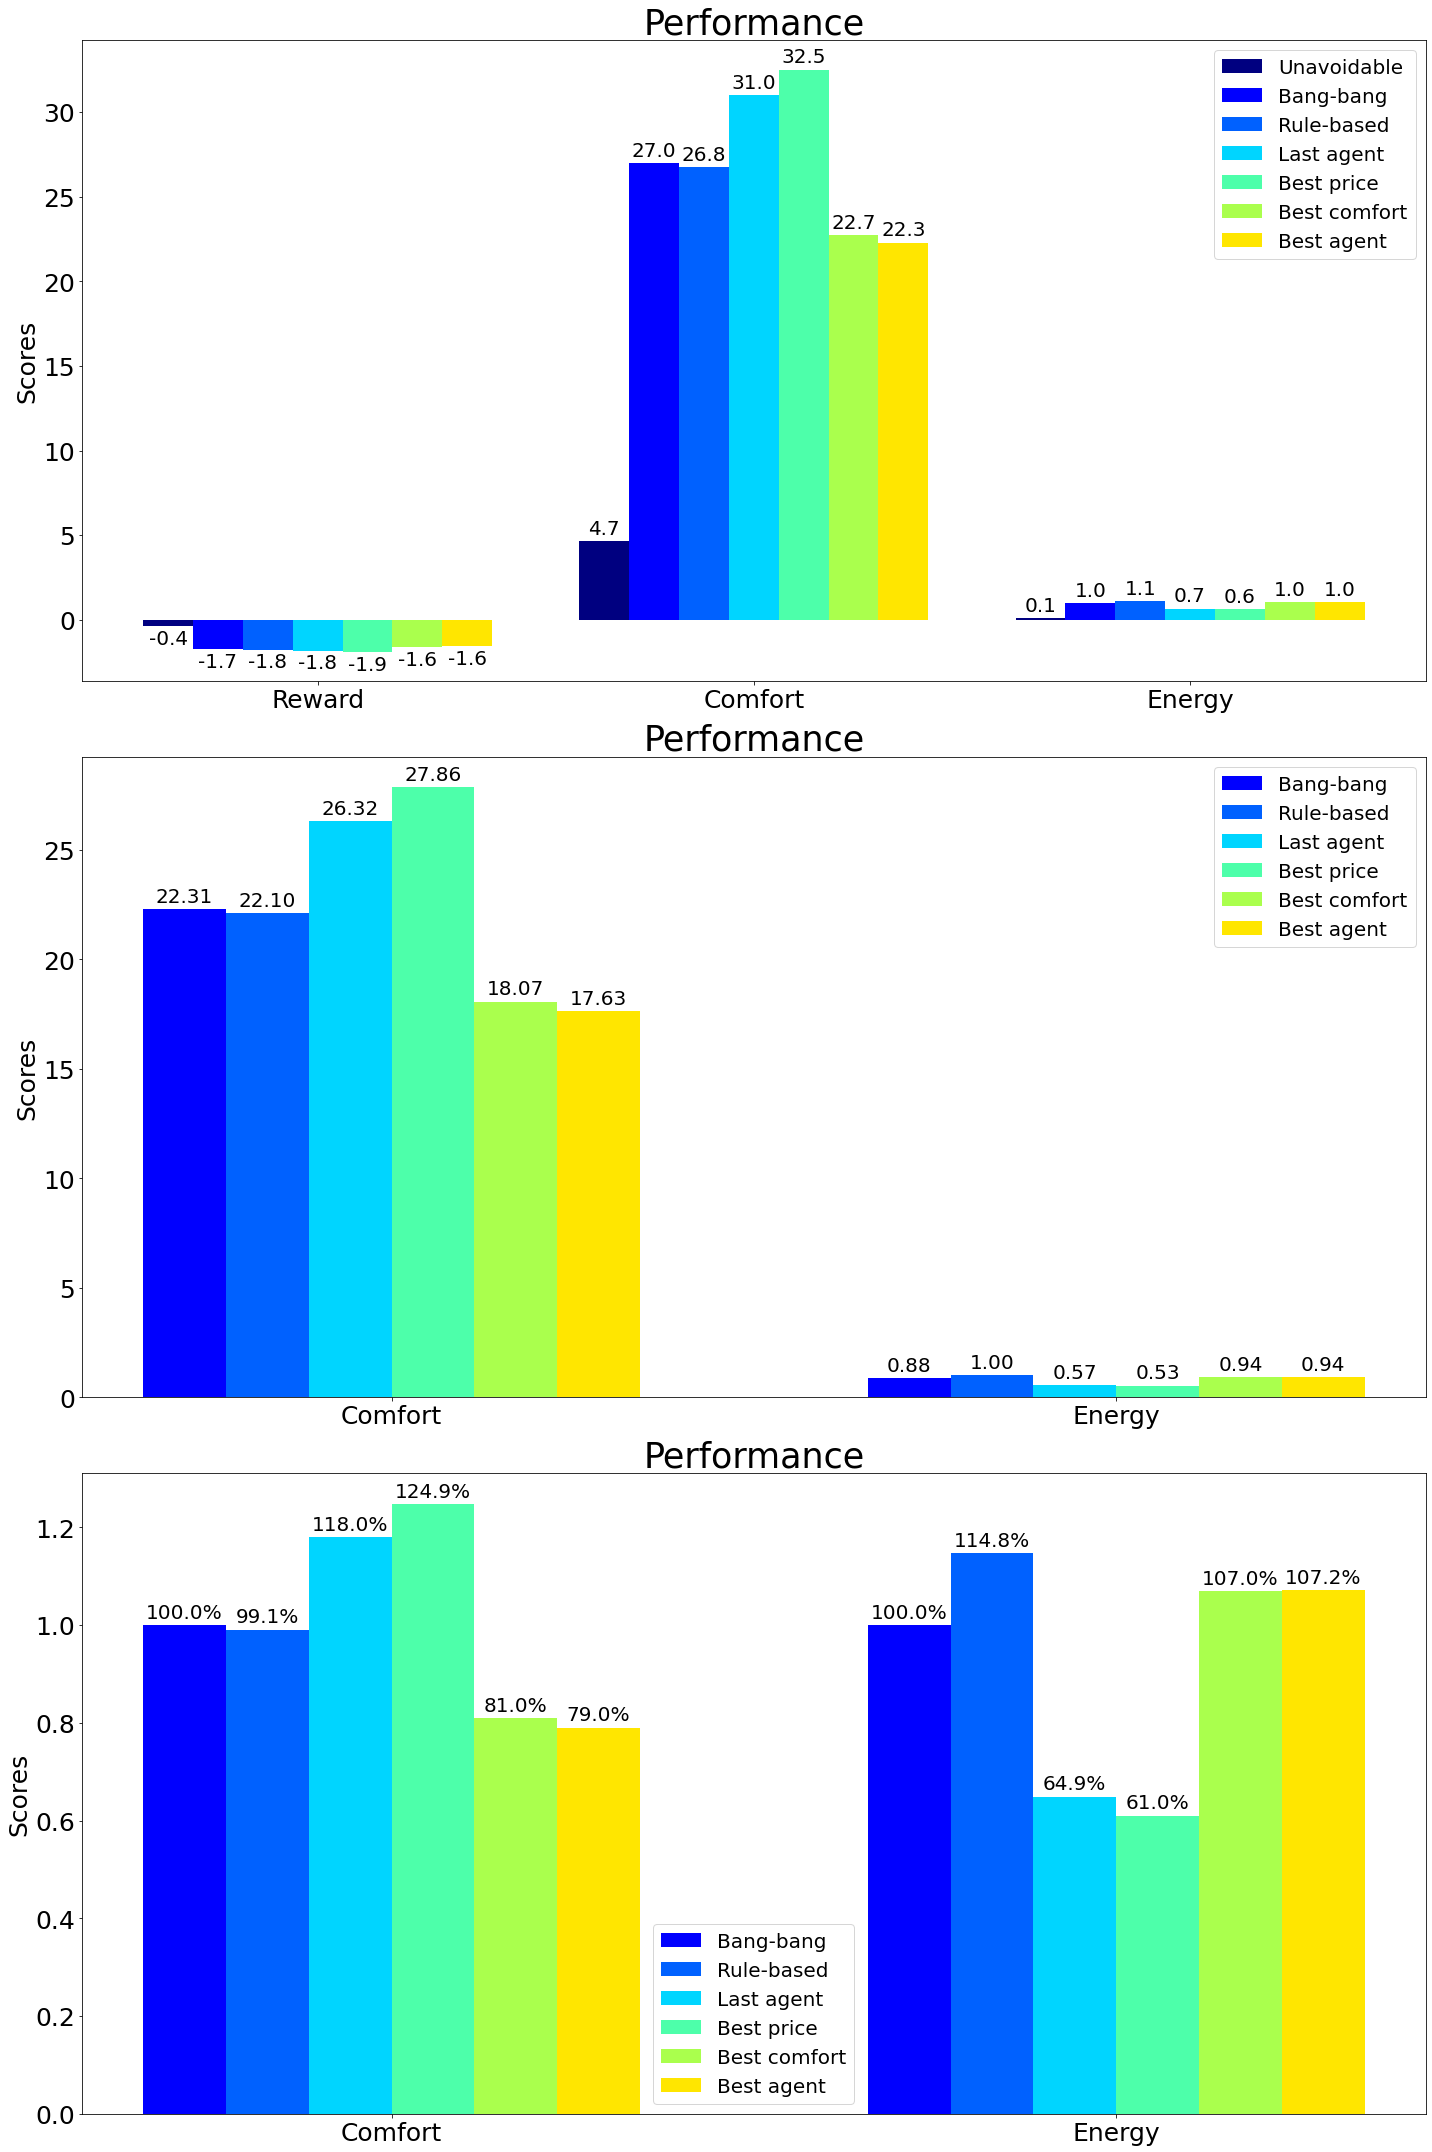

In [17]:
def autolabel(rects, axis, perc=False, small=False):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate(f'{height*100:.1f}%' if perc else f'{height:.1f}' if small else f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3) if height > 0 else (0, -3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top', size=20)
            

def bar_plot_comparison(rewards, comfort_violations, prices):
    
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))

    labels = ["Reward", "Comfort", "Energy"]
    
    data = {}
    for agent in rewards.keys():
        data[agent] = np.array([np.mean([np.sum(x) for x in rewards[agent]]),
                               np.mean([np.sum(x) for x in comfort_violations[agent]]),
                               np.mean([np.sum(x) for x in prices[agent]])])

    x = np.arange(len(labels))  # the label locations
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    ordered_labels = [x for x in ["Unavoidable", "Bang-bang", "Rule-based", "Last agent", "Best price", "Best comfort", "Best agent"] if x in rewards.keys()]
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, 10))
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[0].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[0], small=True) for x in bars]
    ax[0].set_xticklabels(labels)
    ax[0].set_xticks(x)

    for agent in rewards.keys():
        if agent != "Unavoidable":
            data[agent] -= data["Unavoidable"]
    del data["Unavoidable"]

    width = 0.8/len(data.keys()) 

    del ordered_labels[0] 
    colors = colors[1:,:]
    del labels[0]
    for key in data.keys():
        data[key] = data[key][1:]
    x = np.arange(len(labels))
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[1].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[1]) for x in bars]
    ax[1].set_xticklabels(labels)
    ax[1].set_xticks(x)
    
    data2 = {}
    for agent in data.keys():
        data2[agent] = np.array([np.std([np.sum(x) for x in rewards[agent]]),
                               np.std([np.sum(x) for x in comfort_violations[agent]]),
                               np.std([np.sum(x) for x in prices[agent]])])    

    div = data["Bang-bang"].copy()
    for agent in data.keys():
        data[agent] /= div
        
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[2].bar(pos, data[agent], width, label=agent, color=colors[i]))

    [autolabel(x, ax[2], perc=True) for x in bars]
    ax[2].set_xticklabels(labels)
    ax[2].set_xticks(x)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    for axis in ax:
        axis.set_ylabel('Scores', size=25)
        axis.set_title('Performance', size=35)
        axis.tick_params(axis="x", which="major", labelsize=25)
        axis.tick_params(axis="y", which="major", labelsize=25)
        axis.legend()
        axis.legend(prop={'size': 20})

    fig.tight_layout()
    plt.savefig(os.path.join("saves", "Figures", "Performance_nice.pdf"), format="pdf")
    plt.show()
    
    
bar_plot_comparison(rewards, comfort_violations, prices)

In [13]:
if not os.path.isdir(os.path.join("saves", "Experiments", agent_kwargs["name"])):
    os.mkdir(os.path.join("saves", "Experiments", agent_kwargs["name"]))
    
data = pd.DataFrame({key: [np.mean(x) for x in rewards[key]] for key in rewards.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "rewards.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in comfort_violations[key]] for key in comfort_violations.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "comfort.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in prices[key]] for key in prices.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "prices.csv"))

In [6]:
from parameters import prepare_kwargs
data_kwargs, model_kwargs, agent_kwargs, _ = prepare_kwargs(start_date='2018-01-01',
                                                            end_date='2020-10-12',
                                                            model_name="ARX_0",
                                                            agent_name="201208_272_Toy_scale_10_vf_05_lr_000005_ent_0.05_squared_no_cliping",
                                                            rooms=["272"],
                                                            algorithm="PPO2",
                                                            simple_env=True,
                                                            discrete=False,
                                                            backup=False,
                                                            agent_lr=0.00005,
                                                            ent_coef=0.05,
                                                            vf_loss_coef=0.5,
                                                            small_obs=True,
                                                            normalizing=False,
                                                            battery=False,
                                                            temp_bounds=[20, 22, 23, 25],
                                                            ddpg=False,
                                                            gamma=0.95,
                                                            price_levels=[1],
                                                            price_type="Constant",
                                                            lstm_size=128,
                                                            extraction_size=64,
                                                            vf_layers=[64, 64],
                                                            pi_layers=[64, 64],
                                                            n_envs=8)


In [7]:
import numpy as np

def compute_reward(environment, observation, action):
    """
    Small helper function to compute temperature rewards
    """

    reward = 0
    energy_scale = 10

    # Get the current temperatures
    temperatures = environment.scale_back_temperatures(
        environment.current_data[
            environment.n_autoregression + environment.current_step, environment.predictions_columns[
                                                                     :len(environment.rooms)]])

    bounds = (environment.current_data[environment.n_autoregression + environment.current_step, -2:] - 0.1) / 0.8 * (
                environment.temp_bounds[-1] - environment.temp_bounds[0]) + environment.temp_bounds[0]

    too_low = np.where(temperatures < bounds[0])[0]
    too_high = np.where(temperatures > bounds[1])[0]
    right = np.where((temperatures > bounds[0]) & (temperatures < bounds[1]))[0]

    electricity_from_grid = environment.compute_electricity_from_grid(observation, action)
    energy = electricity_from_grid * energy_scale
    
    reward -= energy
                
    if len(too_low) > 0:
        reward += np.sum(temperatures[too_low] - bounds[0])
        if observation[-5] > 0.8999:
            reward -= np.sum((1 - (action[:-1][too_low] - 0.1) / 0.8) * (temperatures[too_low] - bounds[0]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((action[:-1][too_low] - 0.1) / 0.8 * (temperatures[too_low] - bounds[0]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    if len(too_high) > 0:
        reward += np.sum(bounds[1] - temperatures[too_high])
        if observation[-5] > 0.8999:
            reward -= np.sum((action[:-1][too_high] - 0.1) / 0.8 * (bounds[1] - temperatures[too_high]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((1 - (action[:-1][too_high] - 0.1) / 0.8) * (bounds[1] - temperatures[too_high]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")
    return reward, temperatures, bounds

In [8]:
from agents.agents import Agent
agents = {}
types = {}

rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
rl_names = ["Last agent", "Best price", "Best comfort", "Best agent"]

for name in rl_names:
    agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                         load_best="Best agent" in name, load_best_comfort="comfort" in name,
                         load_best_price="price" in name)
    types[name] = "RL"

agents["Unavoidable"] = agents["Best agent"].unavoidable
agents["Bang-bang"] = agents["Best agent"].bangbang
agents["Rule-based"] = agents["Best agent"].rbagent

for name in rb_names:
    types[name] = "RB"



Usage of the TensorBoard is off!


Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Checking the environment...
Creating the subprocesses...
Ready!
Creating the evaluation environment...

Preparing the rule-based agent

Preparing the bang-bang agent

Preparing the unavoidable agent
Rule-based performance on the testing set:
Rewards:              -31.22 +/- 23.91.
Comfort violations:   20.70 +/- 21.58.
Prices:               1.09 +/- 0.52.

Bang-bang performance on the testing set:
Rewards:              -31.38 +/- 25.08.
Comfort violations:   21.95 +/- 22.84.
Prices:               0.99 +/- 0.57.

Unavoidable performance on the testing set:
Rewards:              -4.83 +/- 9.16.
Comfort violations:   4.12 +/- 7.78.
Prices:               0.07 +/- 0.23.

Trying to load an agent...
Found!

Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Checking the environment...
Crea

In [9]:
agents

{'Last agent': <agents.agents.Agent at 0x21a3b9e20c8>,
 'Best price': <agents.agents.Agent at 0x21a4b856948>,
 'Best comfort': <agents.agents.Agent at 0x21a82310448>,
 'Best agent': <agents.agents.Agent at 0x21aa56eaac8>,
 'Unavoidable': <agents.agents.UnavoidableAgent at 0x21acc48de48>,
 'Bang-bang': <agents.agents.BangBangAgent at 0x21acc48d808>,
 'Rule-based': <agents.agents.RBAgent at 0x21acc48d4c8>}

In [10]:
import os
import warnings
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Union, Optional, List, Dict, Any

from stable_baselines.common.vec_env import VecEnv, DummyVecEnv, sync_envs_normalization

from agents.helpers import evaluate_lstm_policy, prepare_performance_plot, analyze_agent
from agents.environments import UMAREnv

from abc import ABC
import typing

from stable_baselines import logger

if typing.TYPE_CHECKING:
    from stable_baselines.common.base_class import BaseRLModel  # pytype: disable=pyi-error
    
    
def prepare_agents(data_kwargs, model_kwargs, agent_kwargs, compute_reward, compute_reward2, rl_names=None):
    
    agents = {}
    types = {}
    
    rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
    if rl_names is None:
        rl_names = ["Best comfort agent", "Best price agent", "Last agent", "Best reward agent"]
    
    for name in rl_names:
        agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                             load_best="reward" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
        types[name] = "RL"
        
    agents["Unavoidable"] = agents["Best reward agent"].unavoidable
    agents["Bang-bang"] = agents["Best reward agent"].bangbang
    agents["Rule-based"] = agents["Best reward agent"].rbagent
    
    for name in rb_names:
        types[name] = "RB"
    
    return agents, types

def analysis(agents, types, eval_env, indices,
             print_: bool = False, print_frequency: int = 25,
             plot_: bool = False, plot_frequency: int = 25,
                 normalizing: bool = False,
                 deterministic: bool = True,
                 verbose: int = 1):

    # Convert to VecEnv for consistency
    if not isinstance(eval_env, VecEnv) and not isinstance(eval_env, UMAREnv):
        eval_env = DummyVecEnv([lambda: eval_env])
        assert eval_env.num_envs == 1, "You must pass only one environment for evaluation"

    _eval_env = eval_env

    if isinstance(eval_env, UMAREnv):
        eval_env = _eval_env
    else:
        if normalizing:
            eval_env = _eval_env.venv.venv.envs[0]
        else:
            eval_env = _eval_env.venv.envs[0]
            
    rewards = {name: [] for name in agents.keys()}
    comfort_violations = {name: [] for name in agents.keys()}
    prices = {name: [] for name in agents.keys()}
            
    for num, index in enumerate(indices):
        
        sequence = np.arange(index-20, index+96)
        
        if num % 50 == 49:
            print(num+1)
        
        for i, name in enumerate(agents.keys()):
            
            if types[name] == "RL":
        
                evaluate_lstm_policy(agents[name].model,
                                     eval_env,
                                     n_eval_episodes=1,
                                     sequence=sequence,
                                     render=False,
                                     deterministic=deterministic,
                                     normalizing=normalizing,
                                     all_goals=False,
                                     return_episode_rewards=True)
            
                rewards[name].append(eval_env.last_rewards)
                comfort_violations[name].append(eval_env.last_comfort_violations)
                prices[name].append(eval_env.last_prices)
            
            else:
        
                agents[name].run(sequence,
                                 eval_env.last_goal_number,
                                 render=False)

                rewards[name].append(agents[name].env.last_rewards)
                comfort_violations[name].append(agents[name].env.last_comfort_violations)
                prices[name].append(agents[name].env.last_prices)
                
            if print_ & (num % print_frequency == 0):
        
                print(f"__________________________\n\n{name}:")
                print(f"\nReward: {np.sum(np.array(rewards[name][-1])):.2f}  -  ", end="")
                print(f"Comfort violations:   {np.sum(np.array(comfort_violations[name][-1])):.2f}  -  ", end="")
                print(f"Total benefits/costs: {np.sum(np.array(prices[name][-1])):.2f}", end="")
                
            if plot_ & (num % plot_frequency == 0):
                
                if types[name] == "RL":
                    env = eval_env
                else:
                    env = agents[name].env

                axes, data = prepare_performance_plot(env=env,
                                                   sequence=env.last_sequence,
                                                   data=env.last_data,
                                                   rewards=env.last_rewards,
                                                   electricity_imports=env.last_electricity_imports,
                                                   lower_bounds=env.last_lower_bounds,
                                                   upper_bounds=env.last_upper_bounds,
                                                   prices=env.last_prices,
                                                   comfort_violations=env.last_comfort_violations,
                                                   battery_soc=env.last_battery_soc,
                                                   battery_powers=env.last_battery_powers,
                                                   label=name,
                                                   elec_price=True if i == 0 else False,
                                                   print_=True if i == 0 else False,
                                                   show_=True if i == len(agents)-1 else False,
                                                    axes=axes if i != 0 else None)


        if plot_ & (num % plot_frequency == 0):
            plt.tight_layout()
            plt.show()
            plt.close()
        
    return rewards, comfort_violations, prices


In [11]:
indices = agents["Best agent"].env.venv.envs[0].umar_model.test_indices
indices = [index for num, index in enumerate(indices) if num % 5 == 0]

In [12]:
rewards, comfort_violations, prices = analysis(agents, types, eval_env=agents["Best agent"].eval_env,
         indices=indices)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100


In [13]:
perc=True
height=3
f'{height*100:.1f}%' if perc else f'{height:.2f}'

'300.0%'

In [14]:
"a" if False else "b" if False else "c"

'c'

In [15]:
colors[0]

{'Last agent': array([34.6711901 , 20.64704174,  0.4935969 ]), 'Best price': array([53.20165624, 23.59466218,  0.42281314]), 'Best comfort': array([24.18044089, 17.81881732,  0.65912802]), 'Best agent': array([25.12142584, 18.00998479,  0.66505677]), 'Bang-bang': array([23.91388444, 21.19347346,  0.5507121 ]), 'Rule-based': array([22.69376034, 19.93614348,  0.54383271])}


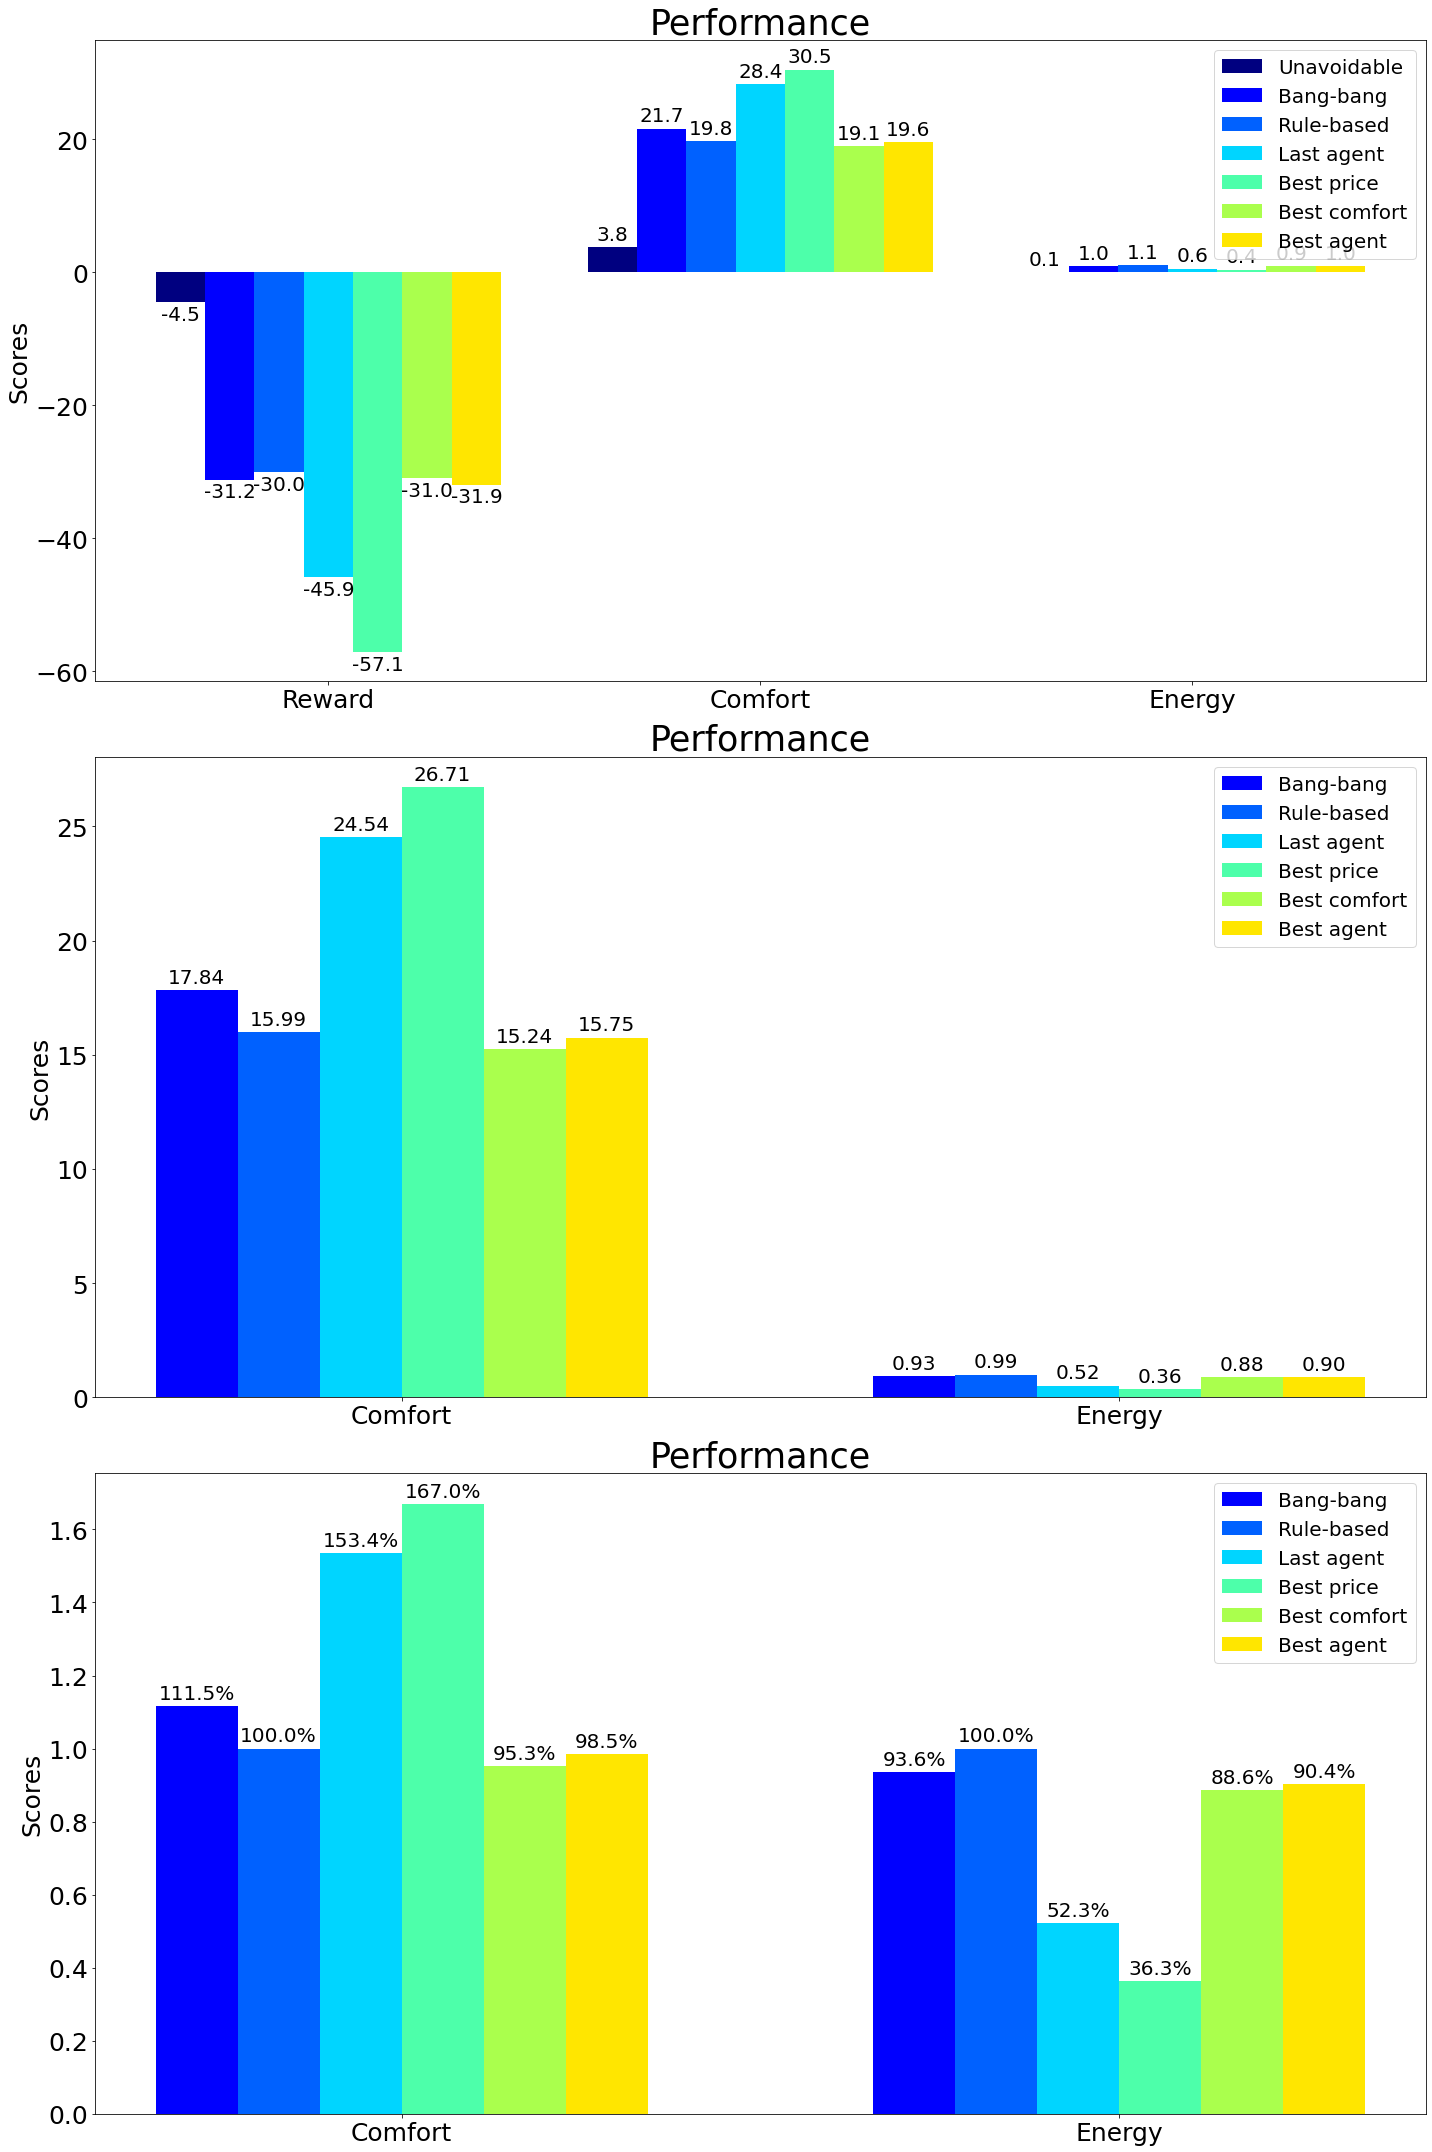

In [16]:
def autolabel(rects, axis, perc=False, small=False):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate(f'{height*100:.1f}%' if perc else f'{height:.1f}' if small else f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3) if height > 0 else (0, -3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top', size=20)
            

def bar_plot_comparison(rewards, comfort_violations, prices):
    
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))

    labels = ["Reward", "Comfort", "Energy"]
    
    data = {}
    for agent in rewards.keys():
        data[agent] = np.array([np.mean([np.sum(x) for x in rewards[agent]]),
                               np.mean([np.sum(x) for x in comfort_violations[agent]]),
                               np.mean([np.sum(x) for x in prices[agent]])])

    x = np.arange(len(labels))  # the label locations
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    ordered_labels = [x for x in ["Unavoidable", "Bang-bang", "Rule-based", "Last agent", "Best price", "Best comfort", "Best agent"] if x in rewards.keys()]
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, 10))
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[0].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[0], small=True) for x in bars]
    ax[0].set_xticklabels(labels)
    ax[0].set_xticks(x)

    for agent in rewards.keys():
        if agent != "Unavoidable":
            data[agent] -= data["Unavoidable"]
    del data["Unavoidable"]

    width = 0.8/len(data.keys()) 

    del ordered_labels[0] 
    colors = colors[1:,:]
    del labels[0]
    for key in data.keys():
        data[key] = data[key][1:]
    x = np.arange(len(labels))
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[1].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[1]) for x in bars]
    ax[1].set_xticklabels(labels)
    ax[1].set_xticks(x)
    
    data2 = {}
    for agent in data.keys():
        data2[agent] = np.array([np.std([np.sum(x) for x in rewards[agent]]),
                               np.std([np.sum(x) for x in comfort_violations[agent]]),
                               np.std([np.sum(x) for x in prices[agent]])])
    print(data2)
    

    div = data["Rule-based"].copy()
    for agent in data.keys():
        data[agent] /= div
        
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[2].bar(pos, data[agent], width, label=agent, color=colors[i]))

    [autolabel(x, ax[2], perc=True) for x in bars]
    ax[2].set_xticklabels(labels)
    ax[2].set_xticks(x)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    for axis in ax:
        axis.set_ylabel('Scores', size=25)
        axis.set_title('Performance', size=35)
        axis.tick_params(axis="x", which="major", labelsize=25)
        axis.tick_params(axis="y", which="major", labelsize=25)
        axis.legend()
        axis.legend(prop={'size': 20})

    fig.tight_layout()
    plt.savefig(os.path.join("saves", "Figures", "Performance_nice.pdf"), format="pdf")
    plt.show()
    
    
bar_plot_comparison(rewards, comfort_violations, prices)

In [33]:
data = pd.DataFrame({key: [np.mean(x) for x in rewards[key]] for key in rewards.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "rewards.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in comfort_violations[key]] for key in comfort_violations.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "comfort.csv"))

data = pd.DataFrame({key: [np.mean(x) for x in prices[key]] for key in prices.keys()})
data.to_csv(os.path.join("saves", "Experiments", agent_kwargs["name"], "prices.csv"))

In [27]:
rew

,Last agent,Best price,Best comfort,Best agent,Unavoidable,Bang-bang,Rule-based
0,-0.314049,-0.225871,-0.180626,-0.033220,0.000000,-0.399295,-0.231648
1,-0.230781,-0.004177,-0.031469,-0.099523,-0.562549,-0.139122,-0.112537
2,-0.940404,-0.709545,-0.542032,-0.082982,-0.150557,-0.006216,-0.149036
3,-0.118358,-0.112595,-0.281697,-0.161686,0.000000,-0.179840,-0.112844
4,-0.655388,-0.031277,-0.003084,-0.012266,0.000000,-0.150727,-0.310262
...,...,...,...,...,...,...,...
1137,-0.946889,-1.965319,-0.210608,-0.119841,0.000000,-0.203769,-0.506007
1138,-0.684890,-1.275081,-0.274153,-0.235146,-0.465769,-0.634786,-0.365572
1139,-0.866009,-1.025453,-0.331123,-0.622594,0.000000,-0.231011,-0.710670
1140,-1.078932,-0.772251,-0.199486,-0.598535,0.000000,-0.155176,-0.339141


{'Last agent': array([22.78620756, 16.62818217,  0.60467146]), 'Best price': array([35.94280051, 20.54944154,  0.49647907]), 'Best comfort': array([24.90655084, 18.03947179,  0.67011509]), 'Best agent': array([25.10526772, 18.40562363,  0.67046794]), 'Bang-bang': array([24.54877301, 21.76932675,  0.56126445]), 'Rule-based': array([22.39032937, 19.94900213,  0.52730129])}


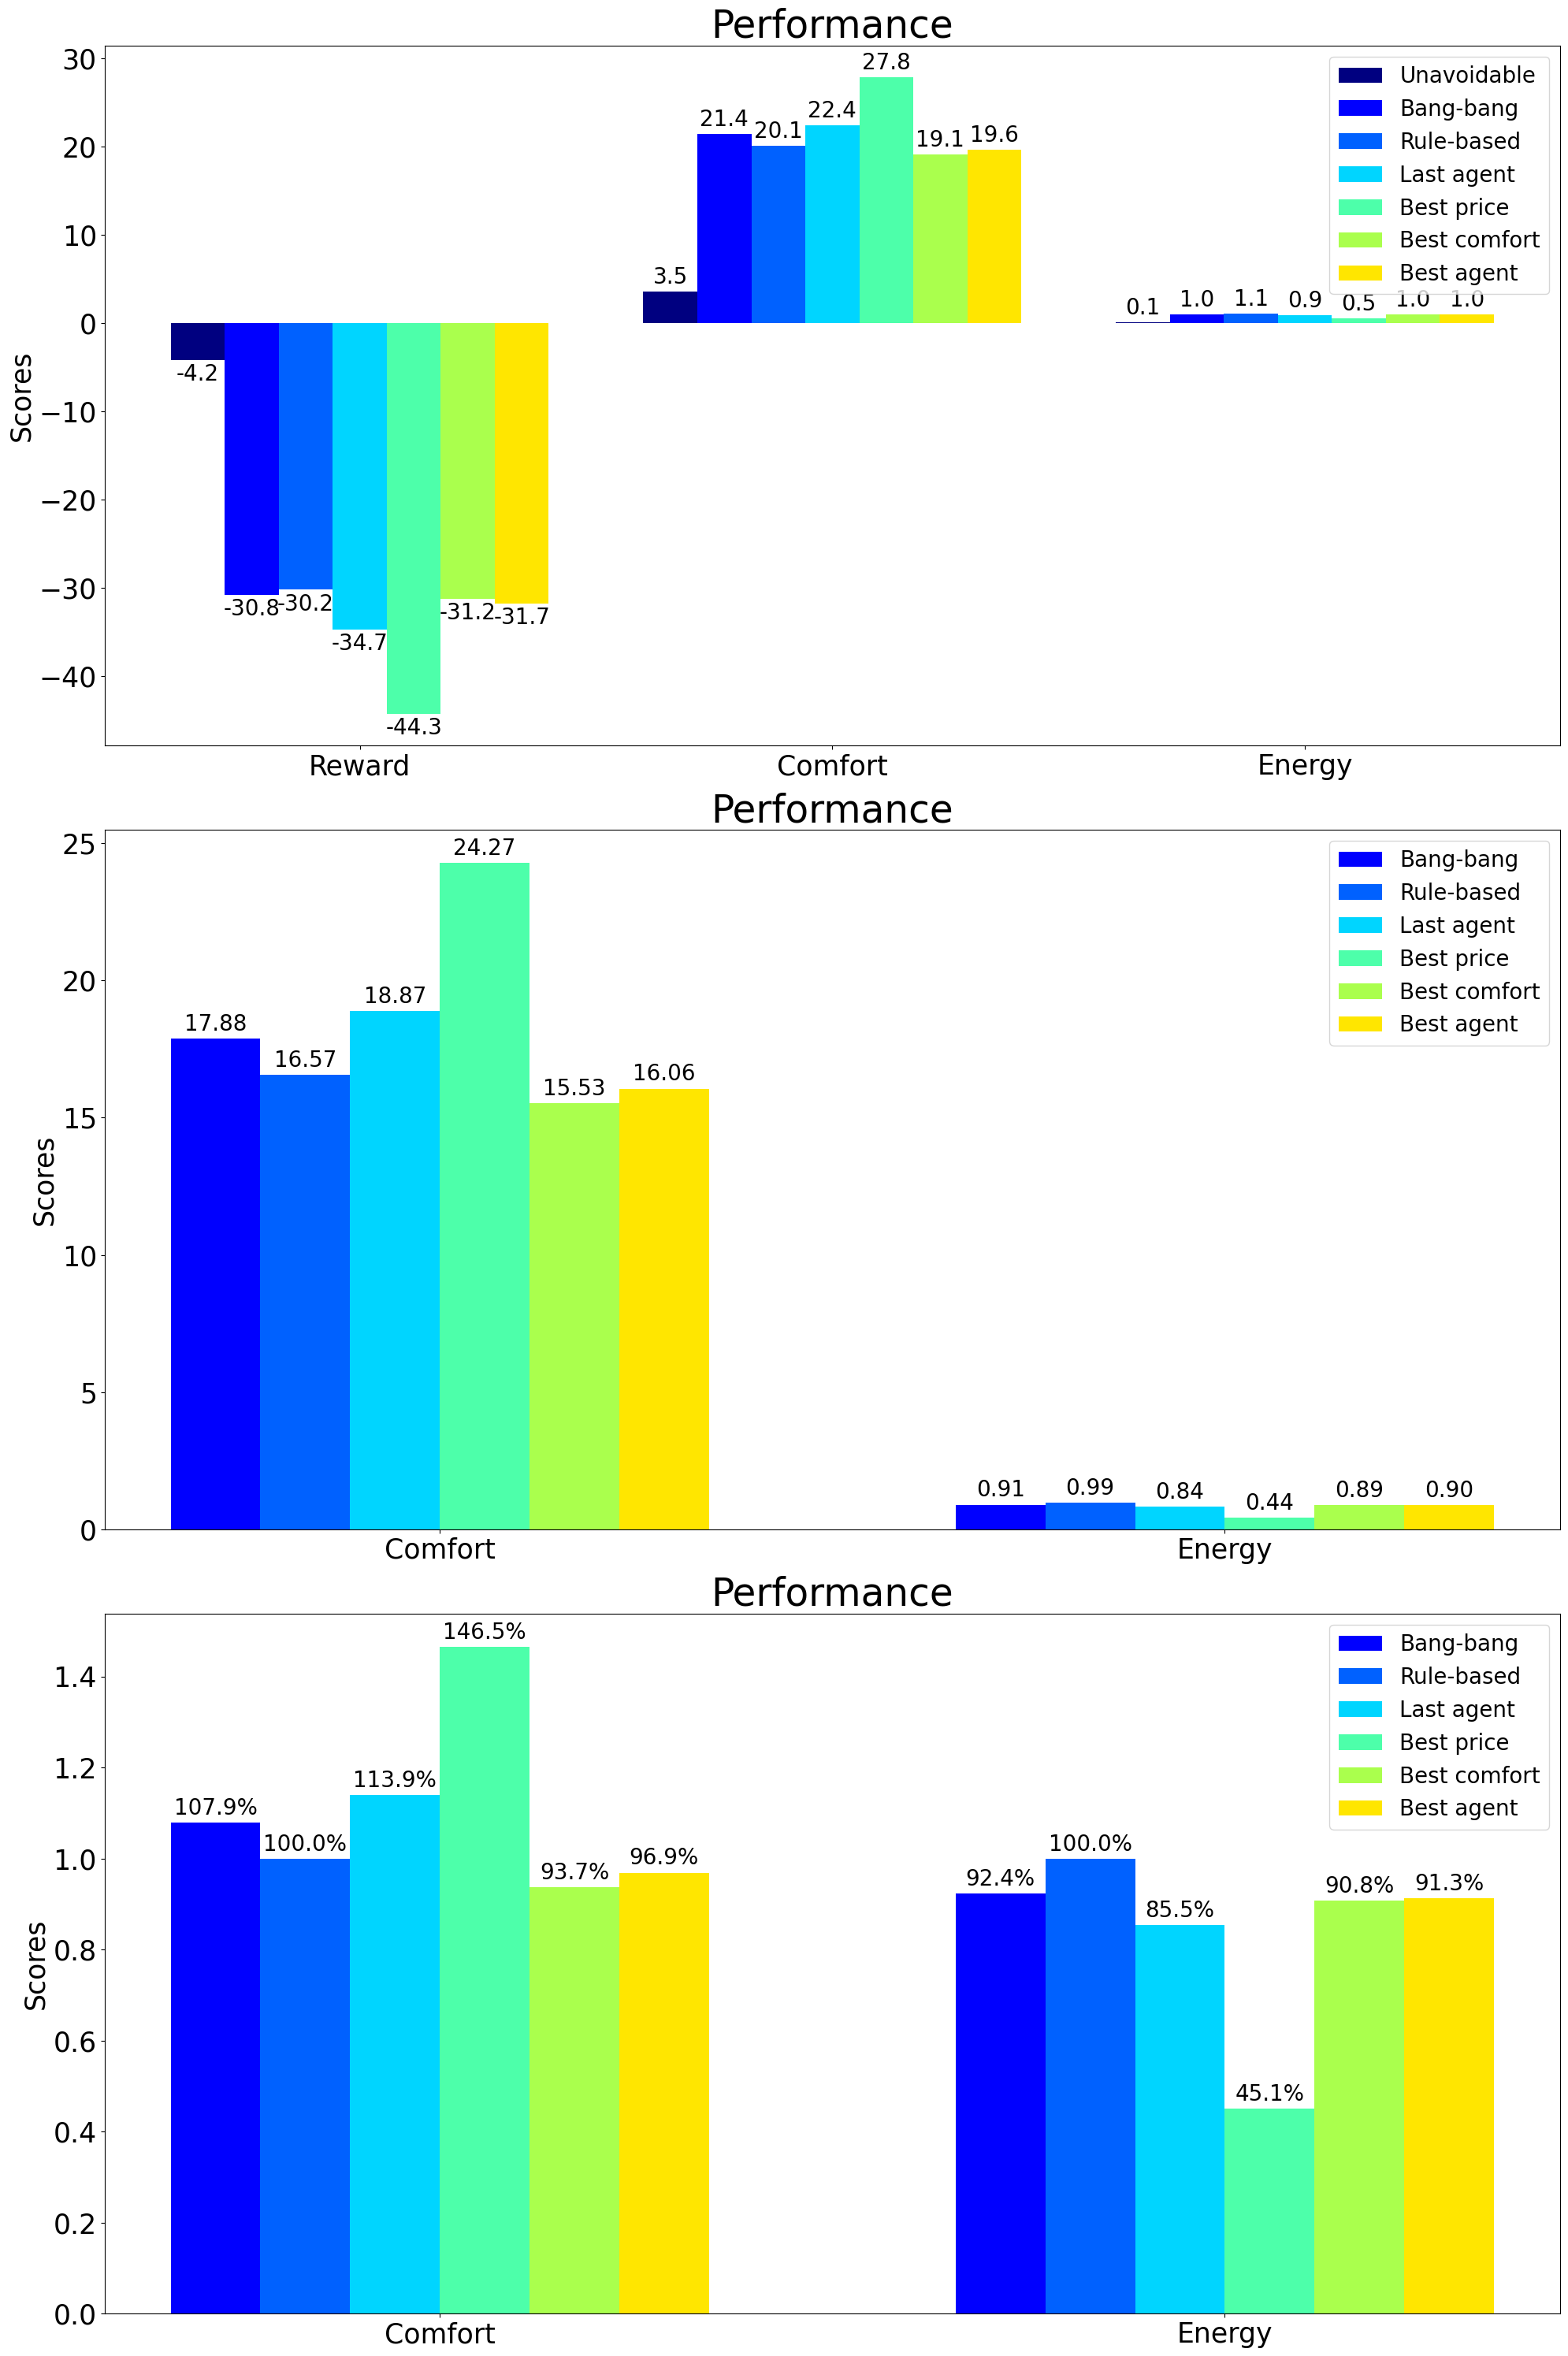

In [74]:
def autolabel(rects, axis, perc=False, small=False):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate(f'{height*100:.1f}%' if perc else f'{height:.1f}' if small else f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3) if height > 0 else (0, -3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top', size=20)
            

def bar_plot_comparison(rewards, comfort_violations, prices):
    
    fig, ax = plt.subplots(3, 1, figsize=(20, 30))

    labels = ["Reward", "Comfort", "Energy"]
    
    data = {}
    for agent in rewards.keys():
        data[agent] = np.array([np.mean([np.sum(x) for x in rewards[agent]]),
                               np.mean([np.sum(x) for x in comfort_violations[agent]]),
                               np.mean([np.sum(x) for x in prices[agent]])])

    x = np.arange(len(labels))  # the label locations
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    ordered_labels = [x for x in ["Unavoidable", "Bang-bang", "Rule-based", "Last agent", "Best price", "Best comfort", "Best agent"] if x in rewards.keys()]
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, 10))
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[0].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[0], small=True) for x in bars]
    ax[0].set_xticklabels(labels)
    ax[0].set_xticks(x)

    for agent in rewards.keys():
        if agent != "Unavoidable":
            data[agent] -= data["Unavoidable"]
    del data["Unavoidable"]

    width = 0.8/len(data.keys()) 

    del ordered_labels[0] 
    colors = colors[1:,:]
    del labels[0]
    for key in data.keys():
        data[key] = data[key][1:]
    x = np.arange(len(labels))
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[1].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[1]) for x in bars]
    ax[1].set_xticklabels(labels)
    ax[1].set_xticks(x)
    
    data2 = {}
    for agent in data.keys():
        data2[agent] = np.array([np.std([np.sum(x) for x in rewards[agent]]),
                               np.std([np.sum(x) for x in comfort_violations[agent]]),
                               np.std([np.sum(x) for x in prices[agent]])])
    print(data2)
    

    div = data["Rule-based"].copy()
    for agent in data.keys():
        data[agent] /= div
        
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[2].bar(pos, data[agent], width, label=agent, color=colors[i]))

    [autolabel(x, ax[2], perc=True) for x in bars]
    ax[2].set_xticklabels(labels)
    ax[2].set_xticks(x)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    for axis in ax:
        axis.set_ylabel('Scores', size=25)
        axis.set_title('Performance', size=35)
        axis.tick_params(axis="x", which="major", labelsize=25)
        axis.tick_params(axis="y", which="major", labelsize=25)
        axis.legend()
        axis.legend(prop={'size': 20})

    fig.tight_layout()
    plt.savefig(os.path.join("saves", "Figures", "Performance_nice.pdf"), format="pdf")
    plt.show()
    
    
bar_plot_comparison(rewards, comfort_violations, prices)

In [72]:
agents["Best agent"].env.venv.envs[0].umar_model.data.iloc[indices,-4]

timestamp
2018-05-23 05:00:00    0.1
2018-05-23 06:15:00    0.1
2018-05-23 07:30:00    0.1
2018-05-23 08:45:00    0.1
2018-05-23 10:00:00    0.1
                      ... 
2018-12-24 09:00:00    0.9
2018-12-24 10:15:00    0.9
2018-12-24 11:30:00    0.9
2018-12-24 12:45:00    0.9
2018-12-24 14:00:00    0.9
Name: Case, Length: 1142, dtype: float64

In [4]:
from parameters import prepare_kwargs
data_kwargs, model_kwargs, agent_kwargs, _ = prepare_kwargs(start_date='2018-01-01',
                                                            end_date='2020-10-12',
                                                            model_name="ARX_0",
                                                            agent_name="201203_272_Toy_scale_1_vf_05_big_arch",
                                                            rooms=["272"],
                                                            algorithm="PPO2",
                                                            simple_env=True,
                                                            discrete=False,
                                                            backup=False,
                                                            vf_loss_coef=0.5,
                                                            small_obs=True,
                                                            normalizing=False,
                                                            battery=False,
                                                            temp_bounds=[20, 22, 23, 25],
                                                            ddpg=False,
                                                            gamma=0.95,
                                                            price_levels=[1],
                                                            price_type="Constant",
                                                            lstm_size=256,
                                                            extraction_size=128,
                                                            vf_layers=[128, 128],
                                                            pi_layers=[128, 128],
                                                            n_envs=8)


data_kwargs2, model_kwargs2, agent_kwargs2, _ = prepare_kwargs(start_date='2018-01-01',
                                                            end_date='2020-10-12',
                                                            model_name="Separated_new",
                                                            hidden_size=64,
                                                            hidden_sizes=[64, 32, 16, 8, 4],
                                                            agent_name="201130_272_scale_2_vf_025_stupid_5",
                                                            rooms=["272"],
                                                            algorithm="PPO2",
                                                            discrete=False,
                                                            backup=False,
                                                            vf_loss_coef=0.25,
                                                            small_obs=True,
                                                            normalizing=False,
                                                            battery=False,
                                                            temp_bounds=[20, 22, 23, 25],
                                                            ddpg=False,
                                                            gamma=0.95,
                                                            price_levels=[1],
                                                            price_type="Constant",
                                                            lstm_size=128,
                                                            extraction_size=64,
                                                            vf_layers=[64, 64],
                                                            pi_layers=[64, 64],
                                                            n_envs=8)

data_kwargs3, model_kwargs3, agent_kwargs3, _ = prepare_kwargs(start_date='2018-01-01',
                                                            end_date='2020-10-12',
                                                            model_name="Separated_new",
                                                            hidden_size=64,
                                                            hidden_sizes=[64, 32, 16, 8, 4],
                                                            agent_name="201201_272_scale_5_vf_025_stupid_squared",
                                                            rooms=["272"],
                                                            algorithm="PPO2",
                                                            discrete=False,
                                                            backup=False,
                                                            vf_loss_coef=0.25,
                                                            small_obs=True,
                                                            normalizing=False,
                                                            battery=False,
                                                            temp_bounds=[20, 22, 23, 25],
                                                            ddpg=False,
                                                            gamma=0.95,
                                                            price_levels=[1],
                                                            price_type="Constant",
                                                            lstm_size=128,
                                                            extraction_size=64,
                                                            vf_layers=[64, 64],
                                                            pi_layers=[64, 64],
                                                            n_envs=8)



In [5]:
import numpy as np

def compute_reward(environment, observation, action):
    """
    Small helper function to compute temperature rewards
    """

    reward = 0
    energy_scale = 1

    # Get the current temperatures
    temperatures = environment.scale_back_temperatures(
        environment.current_data[
            environment.n_autoregression + environment.current_step, environment.predictions_columns[
                                                                     :len(environment.rooms)]])

    bounds = (environment.current_data[environment.n_autoregression + environment.current_step, -2:] - 0.1) / 0.8 * (
                environment.temp_bounds[-1] - environment.temp_bounds[0]) + environment.temp_bounds[0]

    too_low = np.where(temperatures < bounds[0])[0]
    too_high = np.where(temperatures > bounds[1])[0]
    right = np.where((temperatures > bounds[0]) & (temperatures < bounds[1]))[0]

    electricity_from_grid = environment.compute_electricity_from_grid(observation, action)
    energy = electricity_from_grid * energy_scale
    
    reward -= energy
                
    if len(too_low) > 0:
        reward += np.sum(temperatures[too_low] - bounds[0])

    if len(too_high) > 0:
        reward += np.sum(bounds[1] - temperatures[too_high])

    return reward, temperatures, bounds


def compute_reward2(environment, observation, action):
    """
    Small helper function to compute temperature rewards
    """

    reward = 0
    energy_scale = 2

    # Get the current temperatures
    temperatures = environment.scale_back_temperatures(
        environment.current_data[
            environment.n_autoregression + environment.current_step, environment.predictions_columns[
                                                                     :len(environment.rooms)]])

    bounds = (environment.current_data[environment.n_autoregression + environment.current_step, -2:] - 0.1) / 0.8 * (
                environment.temp_bounds[-1] - environment.temp_bounds[0]) + environment.temp_bounds[0]

    too_low = np.where(temperatures < bounds[0])[0]
    too_high = np.where(temperatures > bounds[1])[0]
    right = np.where((temperatures > bounds[0]) & (temperatures < bounds[1]))[0]

    electricity_from_grid = environment.compute_electricity_from_grid(observation, action)
    energy = electricity_from_grid * energy_scale
    
    reward -= energy
                
    if len(too_low) > 0:
        reward += np.sum(temperatures[too_low] - bounds[0])
        if observation[-5] > 0.8999:
            reward += 5*np.sum((1 - (action[:-1][too_low] - 0.1) / 0.8) * (temperatures[too_low] - bounds[0]))
        elif observation[-5] < 0.1001:
            reward += 5*np.sum((action[:-1][too_low] - 0.1) / 0.8 * (temperatures[too_low] - bounds[0]))
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    if len(too_high) > 0:
        reward += np.sum(bounds[1] - temperatures[too_high])
        if observation[-5] > 0.8999:
            reward += 5*np.sum((action[:-1][too_high] - 0.1) / 0.8 * (bounds[1] - temperatures[too_high]))
        elif observation[-5] < 0.1001:
            reward += 5*np.sum((1 - (action[:-1][too_high] - 0.1) / 0.8) * (bounds[1] - temperatures[too_high]))
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    return reward, temperatures, bounds


def compute_reward3(environment, observation, action):
    """
    Small helper function to compute temperature rewards
    """

    reward = 0
    energy_scale = 5

    # Get the current temperatures
    temperatures = environment.scale_back_temperatures(
        environment.current_data[
            environment.n_autoregression + environment.current_step, environment.predictions_columns[
                                                                     :len(environment.rooms)]])

    bounds = (environment.current_data[environment.n_autoregression + environment.current_step, -2:] - 0.1) / 0.8 * (
                environment.temp_bounds[-1] - environment.temp_bounds[0]) + environment.temp_bounds[0]

    too_low = np.where(temperatures < bounds[0])[0]
    too_high = np.where(temperatures > bounds[1])[0]
    right = np.where((temperatures > bounds[0]) & (temperatures < bounds[1]))[0]

    electricity_from_grid = environment.compute_electricity_from_grid(observation, action)
    energy = electricity_from_grid * energy_scale
    
    reward -= energy
                
    if len(too_low) > 0:
        reward += np.sum(temperatures[too_low] - bounds[0])
        if observation[-5] > 0.8999:
            reward -= np.sum((1 - (action[:-1][too_low] - 0.1) / 0.8) * (temperatures[too_low] - bounds[0]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((action[:-1][too_low] - 0.1) / 0.8 * (temperatures[too_low] - bounds[0]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    if len(too_high) > 0:
        reward += np.sum(bounds[1] - temperatures[too_high])
        if observation[-5] > 0.8999:
            reward -= np.sum((action[:-1][too_high] - 0.1) / 0.8 * (bounds[1] - temperatures[too_high]) ** 2)
        elif observation[-5] < 0.1001:
            reward -= np.sum((1 - (action[:-1][too_high] - 0.1) / 0.8) * (bounds[1] - temperatures[too_high]) ** 2)
        else:
            raise ValueError(f"Case has to be 0.1 or 0.9")

    return reward, temperatures, bounds

In [6]:
from agents.agents import Agent
agents = {}
types = {}

rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
rl_names = ["Last agent linear", "Best price linear", "Best comfort linear", "Best agent linear",
            "Last agent quad", "Best price quad", "Best comfort quad", "Best agent quad"]

for name in rl_names:
    if "classical" in name:
        agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                             load_best="Best agent" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
    elif "linear" in name:
        agents[name] = Agent(data_kwargs2, model_kwargs2, agent_kwargs2, compute_reward2,
                             load_best="Best agent" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
    else:
        agents[name] = Agent(data_kwargs3, model_kwargs3, agent_kwargs3, compute_reward3,
                             load_best="Best agent" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
    types[name] = "RL"

agents["Unavoidable"] = agents["Best agent linear"].unavoidable
agents["Bang-bang"] = agents["Best agent linear"].bangbang
agents["Rule-based"] = agents["Best agent linear"].rbagent

for name in rb_names:
    types[name] = "RB"



Usage of the TensorBoard is off!


Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Preparing the data...
Trying to load the full data...
Data downloaded sucessfully!
Dropped 6514 inconsistent points
Dropped 281 inconsistent points

Data ready!

Constructing the LSTM models...
Indeed, the output is currently passed through a sigmoid which crushes it between 0 and 1

Trying to load a trained model...
Found!
The model has been fitted for 388 epochs already, with loss  0.00164.
Trying to load the predictable indices, where the data has no missing values...
Found!
Trying to load the predictable indices, where the data has no missing values...
Found!
Computing common sequences
Checking the environment...
Creating the subprocesses...
Ready!
Creating the evaluation environment...

Preparing the rule-based agent

Preparing the bang-bang agent

Preparing the unavoidable agent
Rule-based performance on the testing set:
Rewards:      

Trying to load the predictable indices, where the data has no missing values...
Found!
Computing common sequences
Checking the environment...
Creating the subprocesses...
Ready!
Creating the evaluation environment...

Preparing the rule-based agent

Preparing the bang-bang agent

Preparing the unavoidable agent
Rule-based performance on the testing set:
Rewards:              -33.55 +/- 36.65.
Comfort violations:   25.87 +/- 32.13.
Prices:               1.58 +/- 1.24.

Bang-bang performance on the testing set:
Rewards:              -33.89 +/- 36.70.
Comfort violations:   26.02 +/- 32.07.
Prices:               1.62 +/- 1.28.

Unavoidable performance on the testing set:
Rewards:              -18.93 +/- 34.68.
Comfort violations:   16.20 +/- 29.42.
Prices:               0.55 +/- 1.18.

Trying to load an agent...
Found!

Preparing the agent
Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.
Preparing the data...
Trying to load the full data...
Data do

In [7]:
agents

{'Last agent linear': <agents.agents.Agent at 0x1c30c430888>,
 'Best price linear': <agents.agents.Agent at 0x1c30cb5eac8>,
 'Best comfort linear': <agents.agents.Agent at 0x1c3bb75c0c8>,
 'Best agent linear': <agents.agents.Agent at 0x1c3d77cf508>,
 'Last agent quad': <agents.agents.Agent at 0x1c408cad748>,
 'Best price quad': <agents.agents.Agent at 0x1c43b369588>,
 'Best comfort quad': <agents.agents.Agent at 0x1c46cb41208>,
 'Best agent quad': <agents.agents.Agent at 0x1c49d2c4648>,
 'Unavoidable': <agents.agents.UnavoidableAgent at 0x1c3ec0e73c8>,
 'Bang-bang': <agents.agents.BangBangAgent at 0x1c3ec0e3dc8>,
 'Rule-based': <agents.agents.RBAgent at 0x1c3ec0e3c48>}

In [8]:
import os
import warnings
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Union, Optional, List, Dict, Any

from stable_baselines.common.vec_env import VecEnv, DummyVecEnv, sync_envs_normalization

from agents.helpers import evaluate_lstm_policy, prepare_performance_plot, analyze_agent
from agents.environments import UMAREnv

from abc import ABC
import typing

from stable_baselines import logger

if typing.TYPE_CHECKING:
    from stable_baselines.common.base_class import BaseRLModel  # pytype: disable=pyi-error
    
    
def prepare_agents(data_kwargs, model_kwargs, agent_kwargs, compute_reward, compute_reward2, rl_names=None):
    
    agents = {}
    types = {}
    
    rb_names = ["Unavoidable", "Bang-bang", "Rule-based"]
    if rl_names is None:
        rl_names = ["Best comfort agent", "Best price agent", "Last agent", "Best reward agent"]
    
    for name in rl_names:
        agents[name] = Agent(data_kwargs, model_kwargs, agent_kwargs, compute_reward,
                             load_best="reward" in name, load_best_comfort="comfort" in name,
                             load_best_price="price" in name)
        types[name] = "RL"
        
    agents["Unavoidable"] = agents["Best reward agent"].unavoidable
    agents["Bang-bang"] = agents["Best reward agent"].bangbang
    agents["Rule-based"] = agents["Best reward agent"].rbagent
    
    for name in rb_names:
        types[name] = "RB"
    
    return agents, types

def analysis(agents, types, eval_env, sequences,
             print_: bool = False, print_frequency: int = 25,
             plot_: bool = False, plot_frequency: int = 25,
                 normalizing: bool = False,
                 deterministic: bool = True,
                 verbose: int = 1):

    # Convert to VecEnv for consistency
    if not isinstance(eval_env, VecEnv) and not isinstance(eval_env, UMAREnv):
        eval_env = DummyVecEnv([lambda: eval_env])
        assert eval_env.num_envs == 1, "You must pass only one environment for evaluation"

    _eval_env = eval_env

    if isinstance(eval_env, UMAREnv):
        eval_env = _eval_env
    else:
        if normalizing:
            eval_env = _eval_env.venv.venv.envs[0]
        else:
            eval_env = _eval_env.venv.envs[0]
            
    rewards = {name: [] for name in agents.keys()}
    comfort_violations = {name: [] for name in agents.keys()}
    prices = {name: [] for name in agents.keys()}
            
    for num, sequence in enumerate(sequences):
        
        if num % 50 == 49:
            print(num+1)
        
        for i, name in enumerate(agents.keys()):
            
            if types[name] == "RL":
        
                evaluate_lstm_policy(agents[name].model,
                                     eval_env,
                                     n_eval_episodes=1,
                                     sequence=sequence,
                                     render=False,
                                     deterministic=deterministic,
                                     normalizing=normalizing,
                                     all_goals=False,
                                     return_episode_rewards=True)
            
                rewards[name].append(eval_env.last_rewards)
                comfort_violations[name].append(eval_env.last_comfort_violations)
                prices[name].append(eval_env.last_prices)
            
            else:
        
                agents[name].run(sequence,
                                 eval_env.last_goal_number,
                                 render=False)

                rewards[name].append(agents[name].env.last_rewards)
                comfort_violations[name].append(agents[name].env.last_comfort_violations)
                prices[name].append(agents[name].env.last_prices)
                
            if print_ & (num % print_frequency == 0):
        
                print(f"__________________________\n\n{name}:")
                print(f"\nReward: {np.sum(np.array(rewards[name][-1])):.2f}  -  ", end="")
                print(f"Comfort violations:   {np.sum(np.array(comfort_violations[name][-1])):.2f}  -  ", end="")
                print(f"Total benefits/costs: {np.sum(np.array(prices[name][-1])):.2f}", end="")
                
            if plot_ & (num % plot_frequency == 0):
                
                if types[name] == "RL":
                    env = eval_env
                else:
                    env = agents[name].env

                axes, data = prepare_performance_plot(env=env,
                                                   sequence=env.last_sequence,
                                                   data=env.last_data,
                                                   rewards=env.last_rewards,
                                                   electricity_imports=env.last_electricity_imports,
                                                   lower_bounds=env.last_lower_bounds,
                                                   upper_bounds=env.last_upper_bounds,
                                                   prices=env.last_prices,
                                                   comfort_violations=env.last_comfort_violations,
                                                   battery_soc=env.last_battery_soc,
                                                   battery_powers=env.last_battery_powers,
                                                   label=name,
                                                   elec_price=True if i == 0 else False,
                                                   print_=True if i == 0 else False,
                                                   show_=True if i == len(agents)-1 else False,
                                                    axes=axes if i != 0 else None)


        if plot_ & (num % plot_frequency == 0):
            plt.tight_layout()
            plt.show()
            plt.close()
        
    return rewards, comfort_violations, prices


In [9]:
rewards, comfort_violations, prices = analysis(agents, types, eval_env=agents["Best agent linear"].eval_env,
         sequences=agents["Best agent linear"].env.venv.envs[0].umar_model.room_models[agent_kwargs["rooms"][0]].test_sequences[500:1500])


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


{'Last agent linear': array([-39.7194362 ,  13.56356321,   0.904043  ]), 'Best price linear': array([-45.30534471,  14.48433962,   0.68172352]), 'Best comfort linear': array([-12.05546934,   8.34353   ,   1.17956503]), 'Best agent linear': array([-12.55963261,   8.39061988,   1.04149759]), 'Last agent quad': array([-33.11850087,  12.38100297,   1.02874786]), 'Best price quad': array([-30.06057756,  12.08807335,   0.85805914]), 'Best comfort quad': array([-13.21738245,   8.33116523,   1.33117588]), 'Best agent quad': array([-13.21738245,   8.33116523,   1.33117588]), 'Bang-bang': array([-12.06136943,  10.48928804,   0.85158054]), 'Rule-based': array([-11.64076413,  10.08182524,   0.84095926])}
{'Last agent linear': array([13.56356321,  0.904043  ]), 'Best price linear': array([14.48433962,  0.68172352]), 'Best comfort linear': array([8.34353   , 1.17956503]), 'Best agent linear': array([8.39061988, 1.04149759]), 'Last agent quad': array([12.38100297,  1.02874786]), 'Best price quad': ar

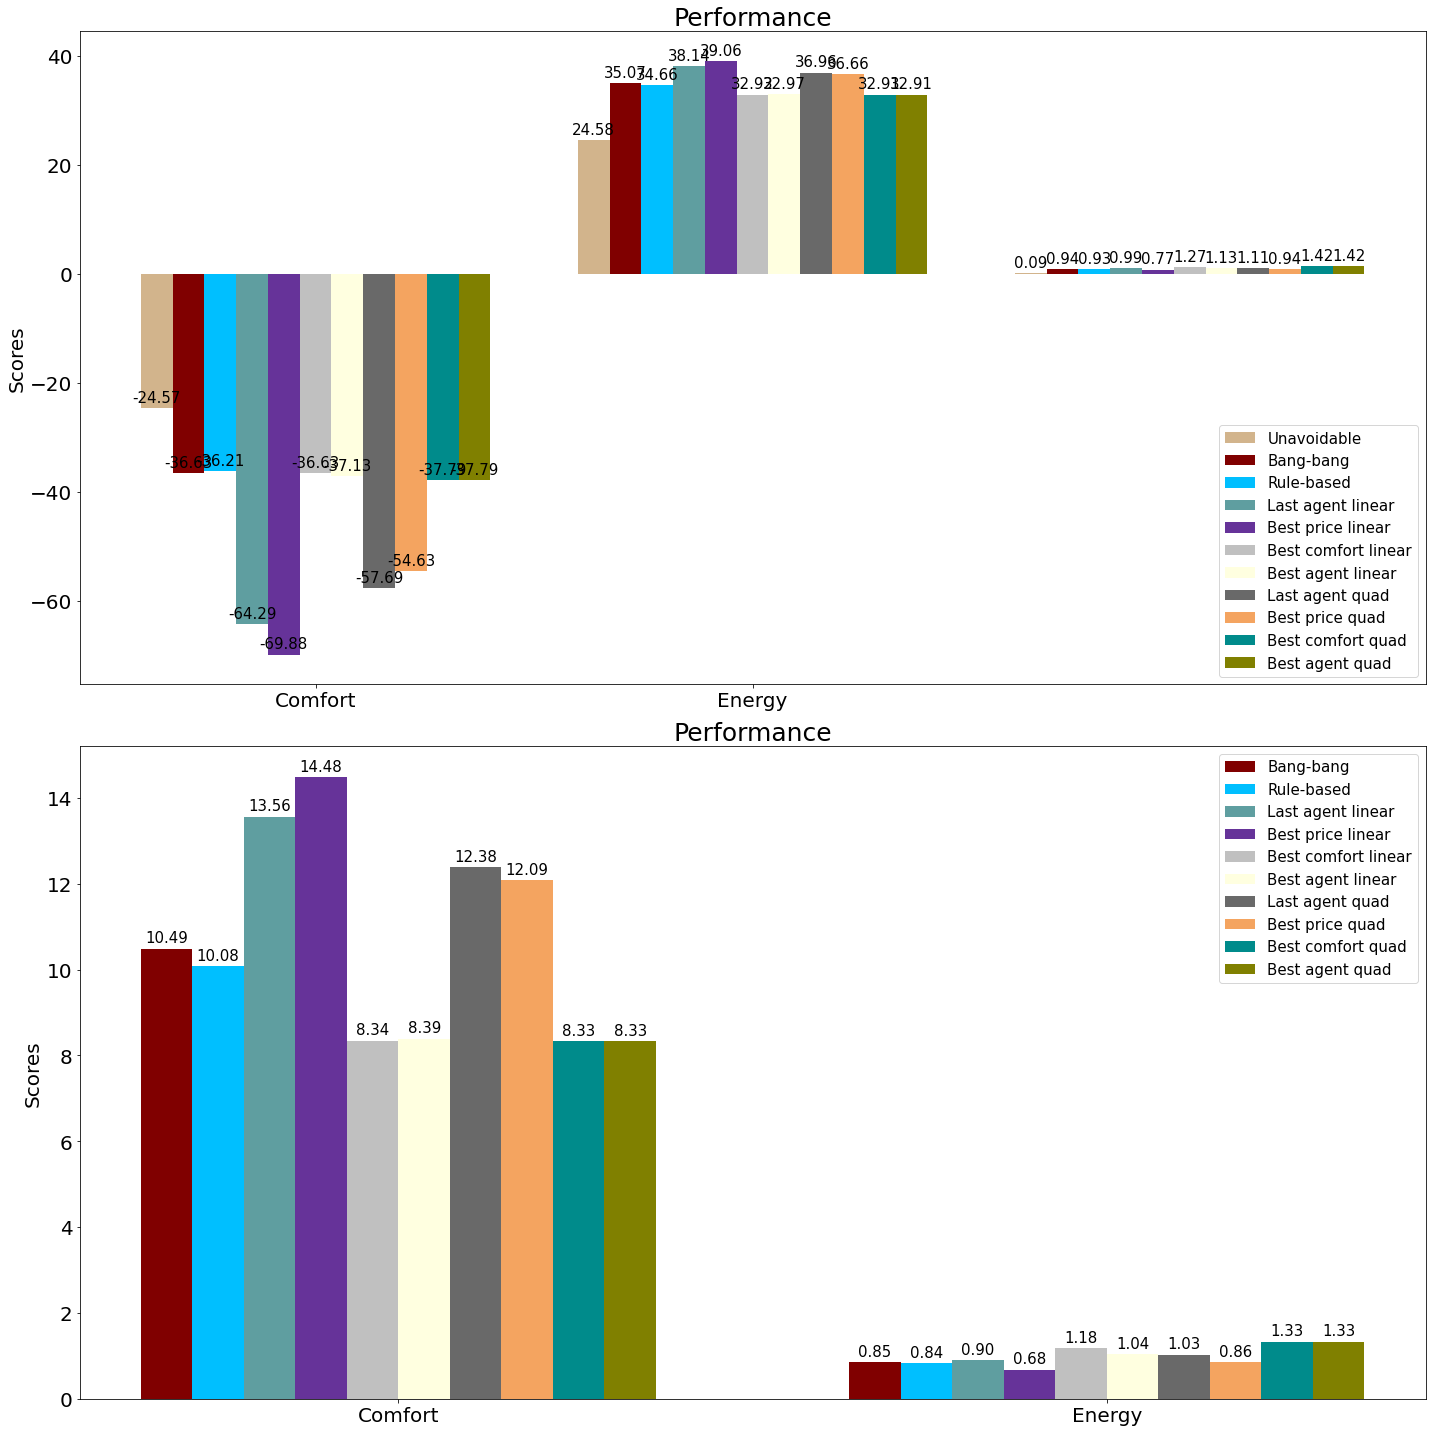

In [10]:
def autolabel(rects, axis):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axis.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size=15)


def bar_plot_comparison(rewards, comfort_violations, prices):
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))

    labels = ["Reward", "Comfort", "Energy"]
    
    data = {}
    for agent in rewards.keys():
        data[agent] = np.array([np.mean([np.sum(x) for x in rewards[agent]]),
                               np.mean([np.sum(x) for x in comfort_violations[agent]]),
                               np.mean([np.sum(x) for x in prices[agent]])])

    x = np.arange(len(labels))  # the label locations
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    ordered_labels = [x for x in ["Unavoidable", "Bang-bang", "Rule-based", "Last agent classical", "Best agent classical",
            "Last agent linear", "Best price linear", "Best comfort linear", "Best agent linear",
            "Last agent quad", "Best price quad", "Best comfort quad", "Best agent quad"] if x in rewards.keys()]
    colors = list(mcolors.CSS4_COLORS)
    np.random.shuffle(colors)
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[0].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[0]) for x in bars]


    for agent in rewards.keys():
        if agent != "Unavoidable":
            data[agent] -= data["Unavoidable"]
    del data["Unavoidable"]

    width = 0.8/len(data.keys()) 

    del ordered_labels[0] 
    del colors[0]
    del labels[0]
    print(data)
    for key in data.keys():
        data[key] = data[key][1:]
    print(data)
    x = np.arange(len(labels))
    width = 0.8/len(rewards.keys())  # the width of the bars
    
    bars = []
    for i, agent in enumerate(ordered_labels):
        if len(ordered_labels) % 2 == 0:
            pos = x + (-len(ordered_labels)/2 + 0.5 + i) * width
        else:
            pos = x + (-(len(ordered_labels)//2) + i) * width        
        bars.append(ax[1].bar(pos, data[agent], width, label=agent, color=colors[i]))
            
    [autolabel(x, ax[1]) for x in bars]

    # Add some text for labels, title and custom x-axis tick labels, etc.
    for axis in ax:
        axis.set_ylabel('Scores', size=20)
        axis.set_title('Performance', size=25)
        axis.set_xticks(x)
        axis.tick_params(axis="x", which="major", labelsize=20)
        axis.tick_params(axis="y", which="major", labelsize=20)
        axis.set_xticklabels(labels)
        axis.legend()
        axis.legend(prop={'size': 15})

    fig.tight_layout()
    plt.show()
    
    
bar_plot_comparison(rewards, comfort_violations, prices)

In [11]:
7.83/9.17, 1.28/0.84

(0.8538713195201745, 1.523809523809524)